In [417]:
import sys
sys.path.append("/richmondvol1/rusty/stompy")

In [418]:
import matplotlib.pyplot as plt
from matplotlib import dates
import xarray as xr
import pandas as pd
import os, glob
import six
from stompy.plot import plot_wkb
from stompy import utils
from matplotlib import gridspec

import seaborn as sns
import numpy as np
%matplotlib notebook

In [419]:
from stompy.grid import unstructured_grid
import stompy.model.delft.dflow_model as dfm

In [420]:
import bloom_common

In [421]:
scene_df=bloom_common.load_chl_scenes()

In [422]:
scene_df

xml   acquisition_start  \
0   rs_chl/04b_log10/20220804_BandMath_BandMath.dim 2022-08-04 18:12:01   
1   rs_chl/04b_log10/20220805_BandMath_BandMath.dim 2022-08-05 18:47:14   
2   rs_chl/04b_log10/20220806_BandMath_BandMath.dim 2022-08-06 18:21:23   
3   rs_chl/04b_log10/20220807_BandMath_BandMath.dim 2022-08-07 17:55:28   
4   rs_chl/04b_log10/20220808_BandMath_BandMath.dim 2022-08-08 18:08:18   
5   rs_chl/04b_log10/20220809_BandMath_BandMath.dim 2022-08-09 18:43:32   
6   rs_chl/04b_log10/20220810_BandMath_BandMath.dim 2022-08-10 18:17:41   
7   rs_chl/04b_log10/20220811_BandMath_BandMath.dim 2022-08-11 18:30:30   
8   rs_chl/04b_log10/20220812_BandMath_BandMath.dim 2022-08-12 18:04:36   
9   rs_chl/04b_log10/20220813_BandMath_BandMath.dim 2022-08-13 18:39:52   
10  rs_chl/04b_log10/20220814_BandMath_BandMath.dim 2022-08-14 18:14:00   
11  rs_chl/04b_log10/20220815_BandMath_BandMath.dim 2022-08-15 18:26:47   
12  rs_chl/04b_log10/20220816_BandMath_BandMath.dim 2022-08-16 18:00:52   
13  rs_chl/04b_log10/20220818_BandMath_BandMath.dim 2022-08-18 18:10:18   
14  rs_chl/04b_log10/20220819_BandMath_BandMath.dim 2022-08-19 18:23:05   
15  rs_chl/04b_log10/20220820_BandMath_BandMath.dim 2022-08-20 17:57:09   
16  rs_chl/04b_log10/20220821_BandMath_BandMath.dim 2022-08-21 18:32:29   
17  rs_chl/04b_log10/20220822_BandMath_BandMath.dim 2022-08-22 18:06:36   
18  rs_chl/04b_log10/20220823_BandMath_BandMath.dim 2022-08-23 18:19:22   
19  rs_chl/04b_log10/20220824_BandMath_BandMath.dim 2022-08-24 17:53:25   
20  rs_chl/04b_log10/20220825_BandMath_BandMath.dim 2022-08-25 18:28:48   
21  rs_chl/04b_log10/20220826_BandMath_BandMath.dim 2022-08-26 18:02:54   
22  rs_chl/04b_log10/20220827_BandMath_BandMath.dim 2022-08-27 18:15:40   
23  rs_chl/04b_log10/20220828_BandMath_BandMath.dim 2022-08-28 18:50:56   
24  rs_chl/04b_log10/20220829_BandMath_BandMath.dim 2022-08-29 18:25:06   
25  rs_chl/04b_log10/20220830_BandMath_BandMath.dim 2022-08-30 17:59:11   
26  rs_chl/04b_log10/20220831_BandMath_BandMath.dim 2022-08-31 18:11:59   

      acquisition_stop  
0  2022-08-04 18:12:20  
1  2022-08-05 18:47:33  
2  2022-08-06 18:21:42  
3  2022-08-07 17:55:46  
4  2022-08-08 18:08:37  
5  2022-08-09 18:43:51  
6  2022-08-10 18:18:00  
7  2022-08-11 18:30:49  
8  2022-08-12 18:04:54  
9  2022-08-13 18:40:11  
10 2022-08-14 18:14:19  
11 2022-08-15 18:27:06  
12 2022-08-16 18:01:11  
13 2022-08-18 18:10:37  
14 2022-08-19 18:23:24  
15 2022-08-20 17:57:28  
16 2022-08-21 18:32:49  
17 2022-08-22 18:06:55  
18 2022-08-23 18:19:41  
19 2022-08-24 17:53:44  
20 2022-08-25 18:29:07  
21 2022-08-26 18:03:13  
22 2022-08-27 18:15:59  
23 2022-08-28 18:51:15  
24 2022-08-29 18:25:25  
25 2022-08-30 17:59:30  
26 2022-08-31 18:12:18

DFM Rotoscope Runs
--

**Next step** is to lay the RS images back on the grid, plot
scatters and look at 
distributions of implied growth rate. For starters this will 
keep the ongoing assumption of vertically mixed.

It's clear that including some notion of vertical distribution will be 
necessary. It may have to be along the lines of bracketing rates based 
on nominal vertical distributions.

In [423]:
six.moves.reload_module(dfm)

#roto_dir="rotodfm_v01" # covers the whole period
# v02 is still running, and adds a swimming version of the tracer and uniform fields
roto_dir="rotodfm_v02"

run_dirs=glob.glob(os.path.join(roto_dir,"run_2022*"))
run_dirs.sort()

run_dirs

['rotodfm_v02/run_20220801T0000_20220804T1812_v00',
 'rotodfm_v02/run_20220801T0000_20220804T1812_v01',
 'rotodfm_v02/run_20220804T1812_20220805T1847_v00',
 'rotodfm_v02/run_20220805T1847_20220806T1821_v00',
 'rotodfm_v02/run_20220806T1821_20220807T1755_v00',
 'rotodfm_v02/run_20220807T1755_20220808T1808_v00',
 'rotodfm_v02/run_20220808T1808_20220809T1843_v00',
 'rotodfm_v02/run_20220809T1843_20220810T1817_v00',
 'rotodfm_v02/run_20220810T1817_20220811T1830_v00',
 'rotodfm_v02/run_20220811T1830_20220812T1804_v00',
 'rotodfm_v02/run_20220812T1804_20220813T1839_v00',
 'rotodfm_v02/run_20220813T1839_20220814T1814_v00',
 'rotodfm_v02/run_20220814T1814_20220815T1826_v00',
 'rotodfm_v02/run_20220815T1826_20220816T1800_v00',
 'rotodfm_v02/run_20220816T1800_20220818T1810_v00',
 'rotodfm_v02/run_20220818T1810_20220819T1823_v00',
 'rotodfm_v02/run_20220819T1823_20220820T1757_v00',
 'rotodfm_v02/run_20220820T1757_20220821T1832_v00',
 'rotodfm_v02/run_20220821T1832_20220822T1806_v00',
 'rotodfm_v0

In [444]:
class RotoPlot:
    uniform_var=None
    weight_var="weight0"
    weight_value_var="wvalue0"
    zoom=(529348.6949125907, 577019.3517870362, 4156965.4523581555, 4192441.2900321614)
    
    def __init__(self,model,**kw):
        fig,axs=plt.subplots(3,3,figsize=(9,8),
                             gridspec_kw=dict(width_ratios=[0.48,0.48,0.02]))
        fig.subplots_adjust(left=0.01, right=0.93, top=0.99, bottom=0.01,
                            hspace=0.04,wspace=0.04)
        self.fig=fig
        self.axs=axs
        
        for ax in axs[:,:-1].ravel():
            ax.set_adjustable('datalim')
            ax.axis('off')

        # Top left: initial condition

        layer_kw=dict(laydim=-1) # dfm surface

        # Load from model
        map_ds=model.map_dataset()
        poly=map_ds.grid.boundary_polygon()
        
        chl_clim=[0,100]
        for col,tidx in enumerate([0,-1]): # loop over [start,stop] time
            snap=map_ds.isel(time=tidx,**layer_kw)
            weight=snap[self.weight_var].values
            min_weight=0.0001
            invalid=weight<min_weight
            value = snap[self.weight_value_var].values / np.maximum(weight,min_weight)
            value[invalid]=np.nan

            ax=axs[0,col]
            coll_weight=map_ds.grid.plot_cells(values=weight, cmap='viridis',clim=[0,1], ax=ax,
                                               edgecolor='face',lw=0.5)

            ax=axs[1,col]
            coll_value=map_ds.grid.plot_cells(values=value, cmap='turbo',clim=chl_clim, ax=ax,
                                              edgecolor='face',lw=0.5)

            t=snap.time
            t_str=t.dt.strftime('%Y-%m-%d %H:%M').item()
            ax.text(0.57, 0.98,t_str,va='top',transform=ax.transAxes)

            # And the corresponding RS data
            scene_idx=np.searchsorted(scene_df.acquisition_start, t.values)
            ax=axs[2,col]
            # In at least one case (08/25) this comes back with some bad coodinates
            xyz=bloom_common.load_scene_utm(scene_df.xml.values[scene_idx],ravel=False)
            coll_rs=bloom_common.plot_xyz(xyz,ax=ax,cmap='turbo')
            coll_rs.set_clim(chl_clim)
            ax.set_aspect(1.0)

            for ax in axs[:,col]:
                plot_wkb.plot_wkb(poly,fc='0.9',ec='none',lw=0.0,zorder=-1,ax=ax)
                plot_wkb.plot_wkb(poly,fc='none',ec='k',lw=0.5,zorder=3,ax=ax)
                ax.axis(self.zoom)

        for i,(coll,label) in enumerate(zip([coll_weight,coll_value,coll_rs],
                                            ['weight','value','RS'])):
            cax=axs[i,-1]
            plt.colorbar(coll,cax=cax,label=label)
        
      

Swimming Tests
--

Know that just using `wvalue1`/`weight1` to recover the value will not work, 
since it 'undoes' the concentration due to swimming.

Option A:
Depth-averaged weight1 *is* a measure of how much tagged water volume contributed
to the tracer in the cell. Maybe it's sufficient to just normalize by the depth-averaged
weight?

Option B:
Use the passive tracer, and redistribute according to uniform tracer with swimming. This
ignores any horizontal transport effects from buoyancy, but is simple and robust.



In [ ]:
# Exploring the swimming tracers
model=dfm.DFlowModel.load(run_dirs[5])

In [441]:
map_ds=model.map_dataset()

<IPython.core.display.Javascript object>


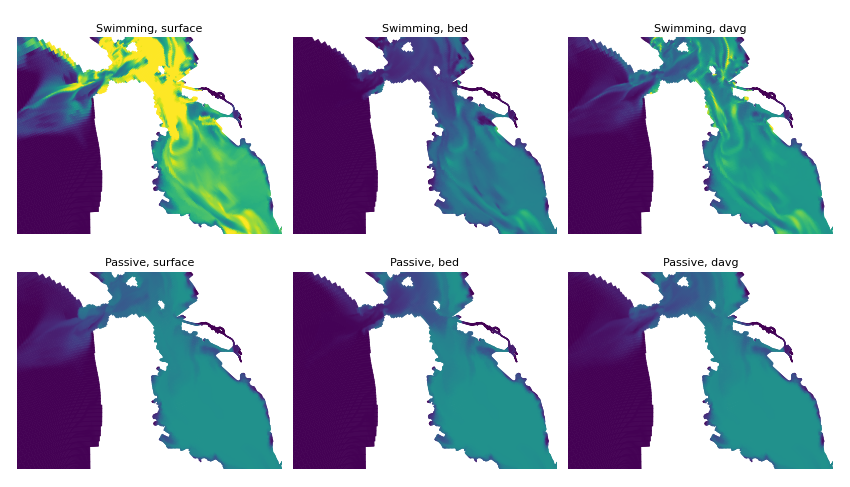

In [457]:
# Side-by-side plots of surface vs bed.
swims={'1':'Swimming',
       '0':'Passive'}

columns=['surface','bed','davg']

fig,axs=plt.subplots(len(swims),len(columns))

g=map_ds.grid
snap=map_ds.isel(time=-1)
kw=dict(edgecolor='face',lw=0.5)
t_kw=dict(pad=4,fontsize=8)


for coli,col in enumerate(columns): # vertical 
    for rowi,row in enumerate(swims): # swimming vs passive
        values=snap['weight'+row]
        if col=='surface': 
            values=values.isel(laydim=-1)
        elif col=='bed':
            values=values.isel(laydim=0)
        elif col=='davg':
            values=values.compute().mean(dim='laydim')
            
        ax=axs[rowi,coli]
        g.plot_cells(values=values,clim=[0,2],cmap='viridis',ax=ax,**kw)

        ax.set_title(swims[row]+", "+col,**t_kw)

        ax.axis('off')
        ax.axis(RotoPlot.zoom)
    
fig.subplots_adjust(left=0.02,right=0.98,top=0.94,bottom=0.02,wspace=0.04,hspace=0.10)

In [ ]:
# Side-by-side plots of surface vs bed.
fig,axs=plt.subplots(2,2)

g=map_ds.grid

snap=map_ds.isel(time=-1)
kw=dict(edgecolor='face',lw=0.5)

g.plot_cells(values=snap['weight1'].isel(laydim=-1),clim=[0,2],cmap='viridis',ax=axs[0,0],**kw)
g.plot_cells(values=snap['weight1'].isel(laydim=0),clim=[0,2],cmap='viridis',ax=axs[0,1],**kw)

g.plot_cells(values=snap['weight0'].isel(laydim=-1),clim=[0,2],cmap='viridis',ax=axs[1,0],**kw)
g.plot_cells(values=snap['weight0'].isel(laydim=0),clim=[0,2],cmap='viridis',ax=axs[1,1],**kw)

t_kw=dict(pad=4,fontsize=8)
axs[0,0].set_title("Swimming, Surface",**t_kw)
axs[0,1].set_title("Swimming, Bed",**t_kw)
axs[1,0].set_title("Passive, Surface",**t_kw)
axs[1,1].set_title("Passive, Bed",**t_kw)

for ax in axs.ravel():
    ax.axis('off')
    ax.axis(RotoPlot.zoom)
    
fig.subplots_adjust(left=0.02,right=0.98,top=0.94,bottom=0.02,wspace=0.04,hspace=0.10)

<IPython.core.display.Javascript object>


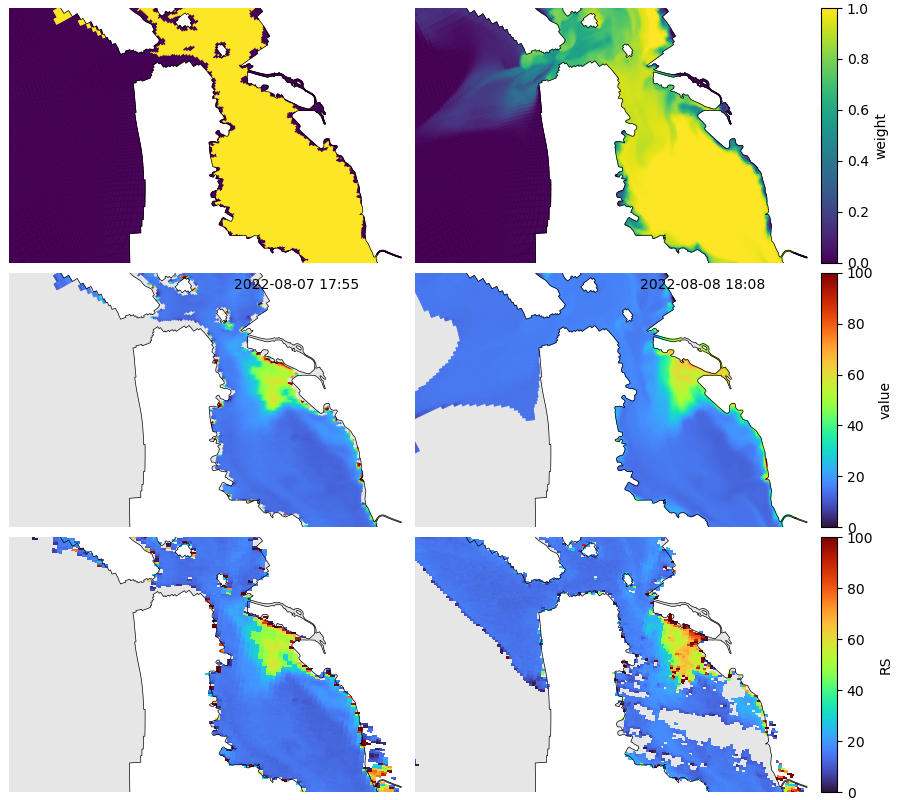

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
INFO:UnstructuredGrid:Warning, boundary_polygon() failed using edges!  Trying polygon union method


In [440]:
rp=RotoPlot(model,weight_var='weight1',weight_value_var='wvalue1')

<IPython.core.display.Javascript object>


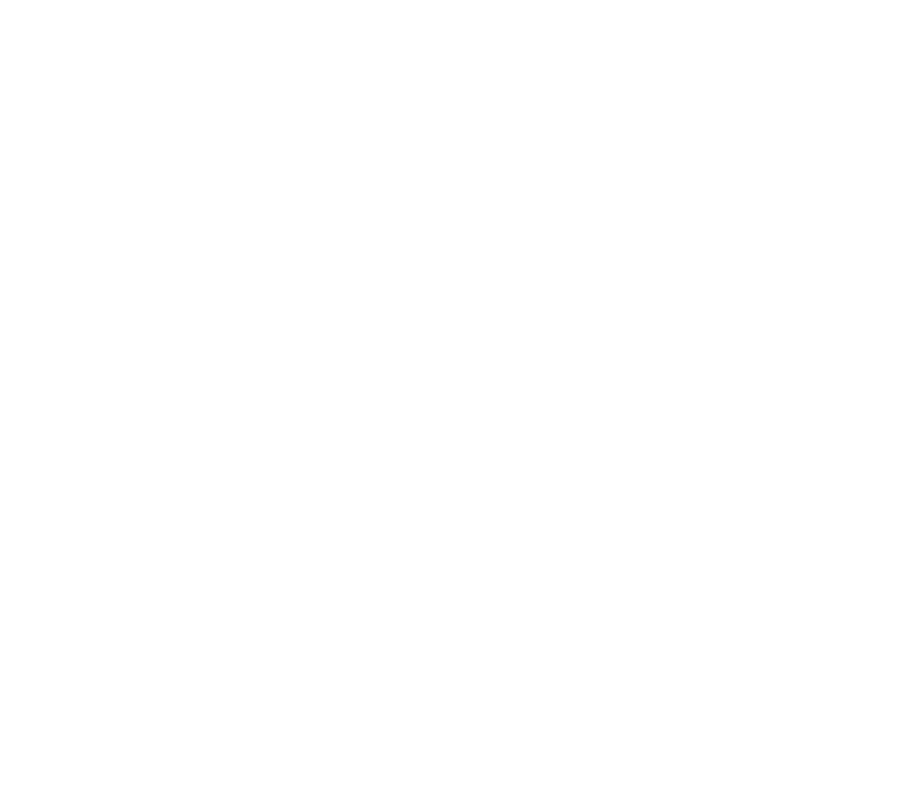

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
INFO:UnstructuredGrid:Warning, boundary_polygon() failed using edges!  Trying polygon union method


<IPython.core.display.Javascript object>


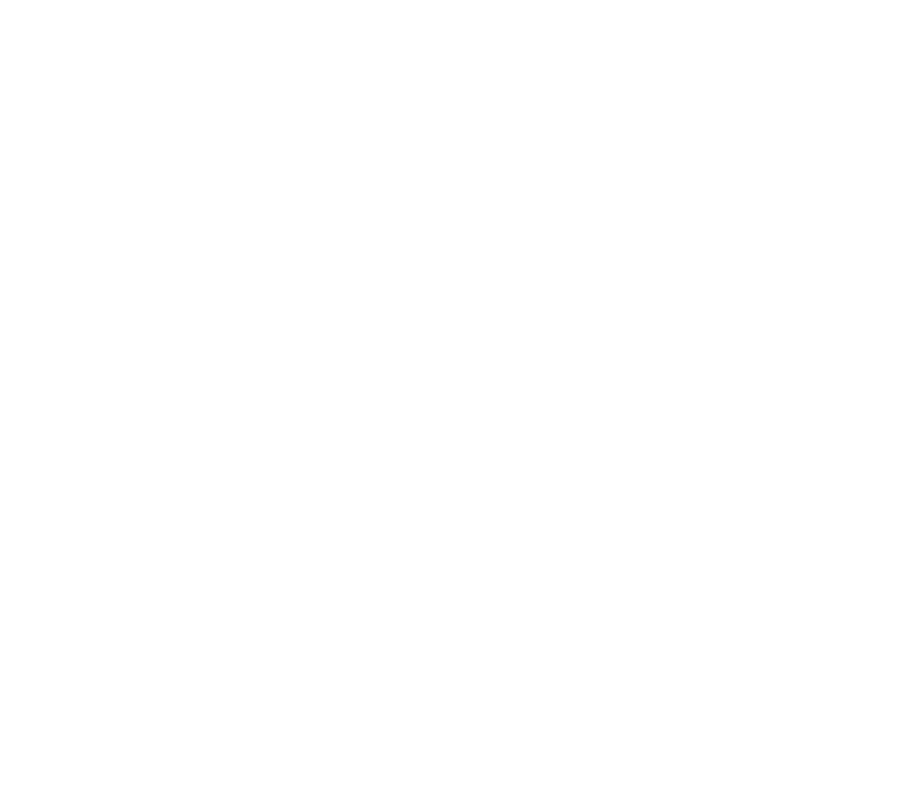

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
INFO:UnstructuredGrid:Warning, boundary_polygon() failed using edges!  Trying polygon union method


<IPython.core.display.Javascript object>


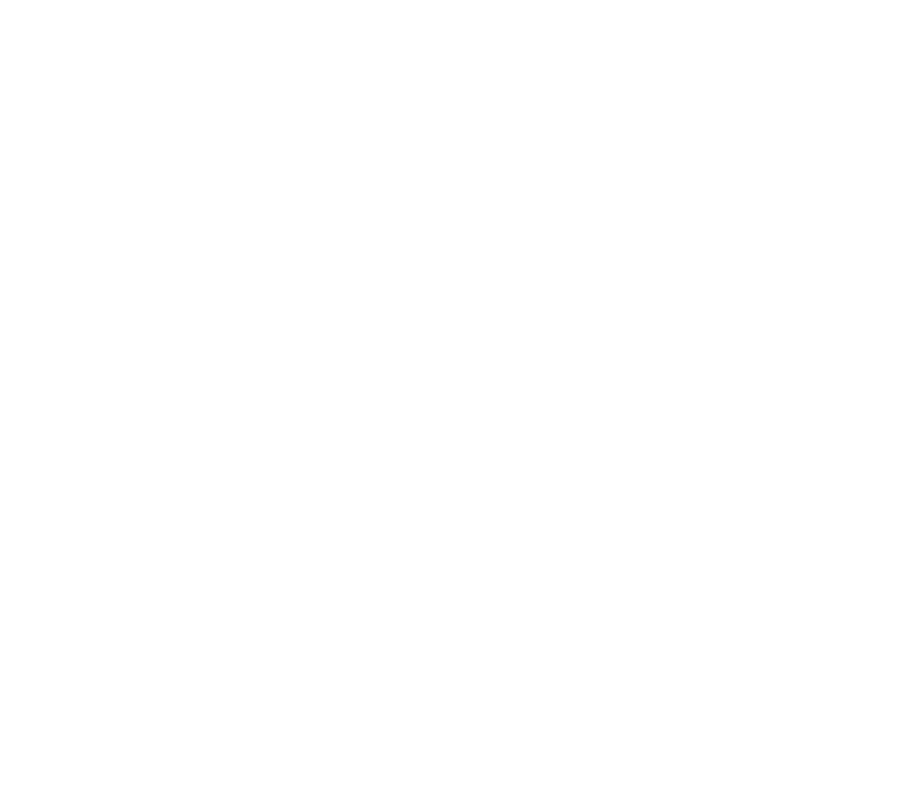

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
INFO:UnstructuredGrid:Warning, boundary_polygon() failed using edges!  Trying polygon union method


<IPython.core.display.Javascript object>


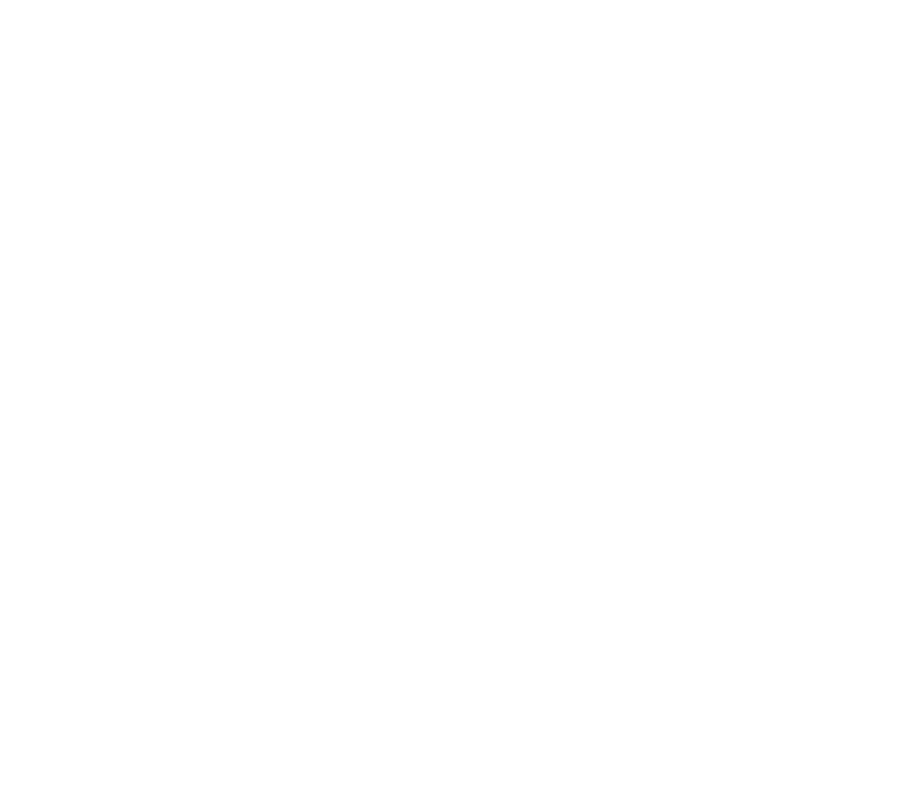

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
INFO:UnstructuredGrid:Warning, boundary_polygon() failed using edges!  Trying polygon union method


<IPython.core.display.Javascript object>


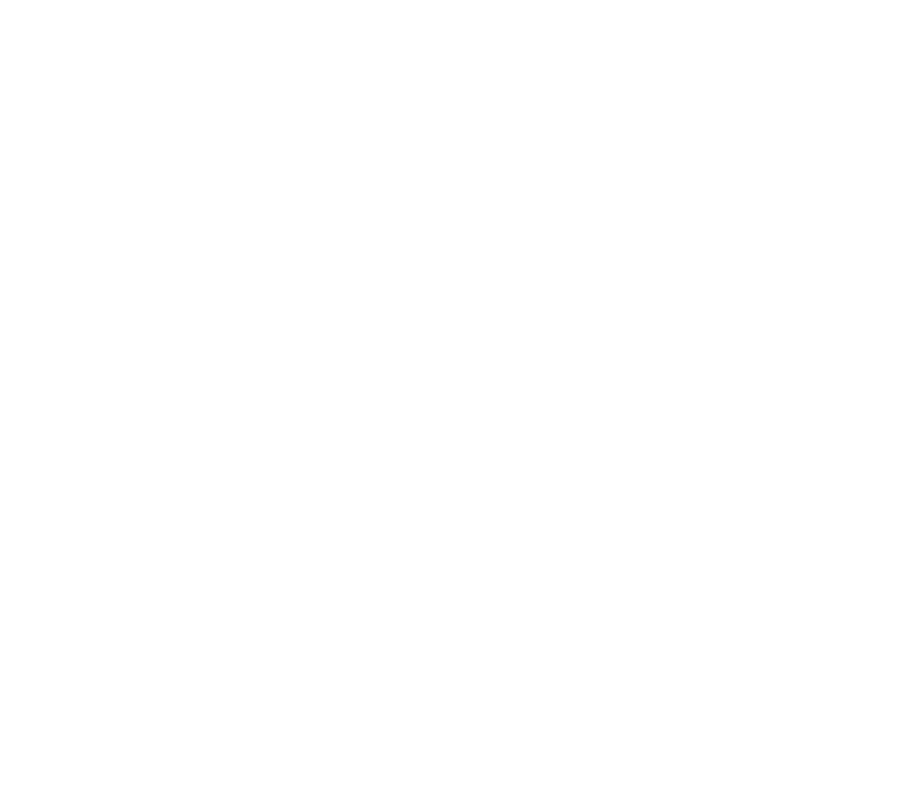

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
INFO:UnstructuredGrid:Warning, boundary_polygon() failed using edges!  Trying polygon union method


<IPython.core.display.Javascript object>


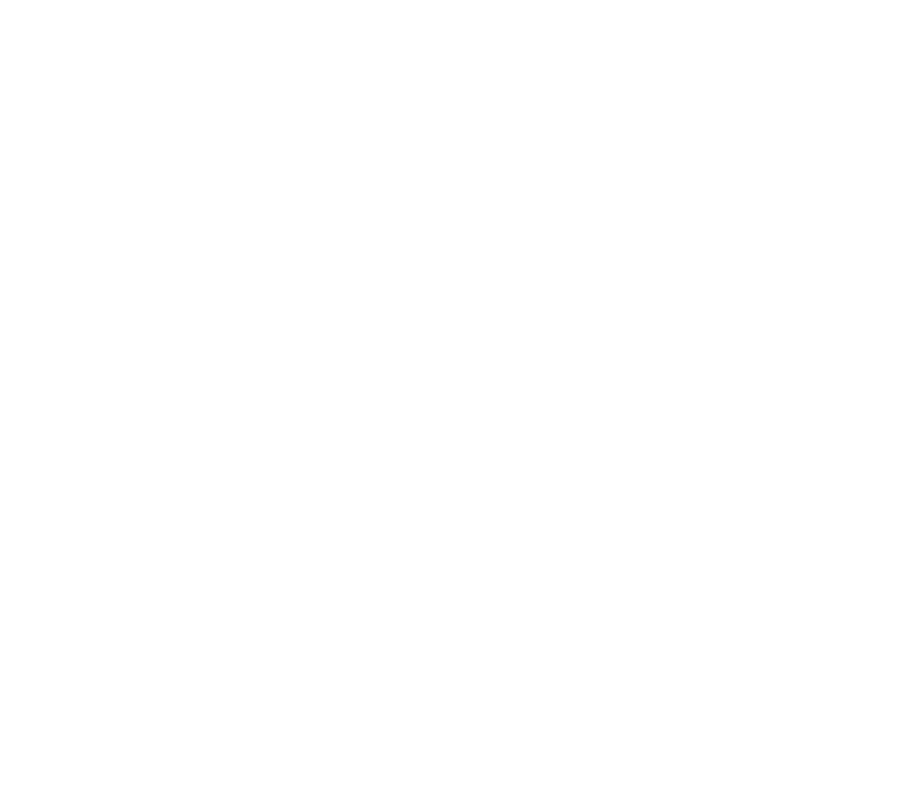

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
INFO:UnstructuredGrid:Warning, boundary_polygon() failed using edges!  Trying polygon union method


<IPython.core.display.Javascript object>


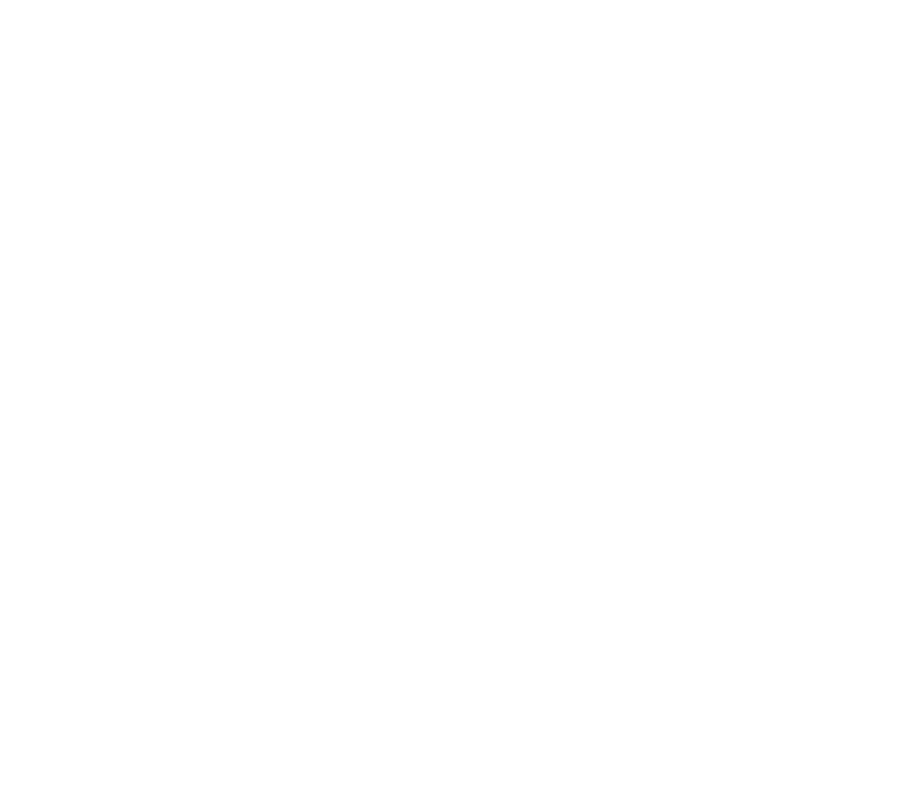

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
INFO:UnstructuredGrid:Warning, boundary_polygon() failed using edges!  Trying polygon union method


<IPython.core.display.Javascript object>


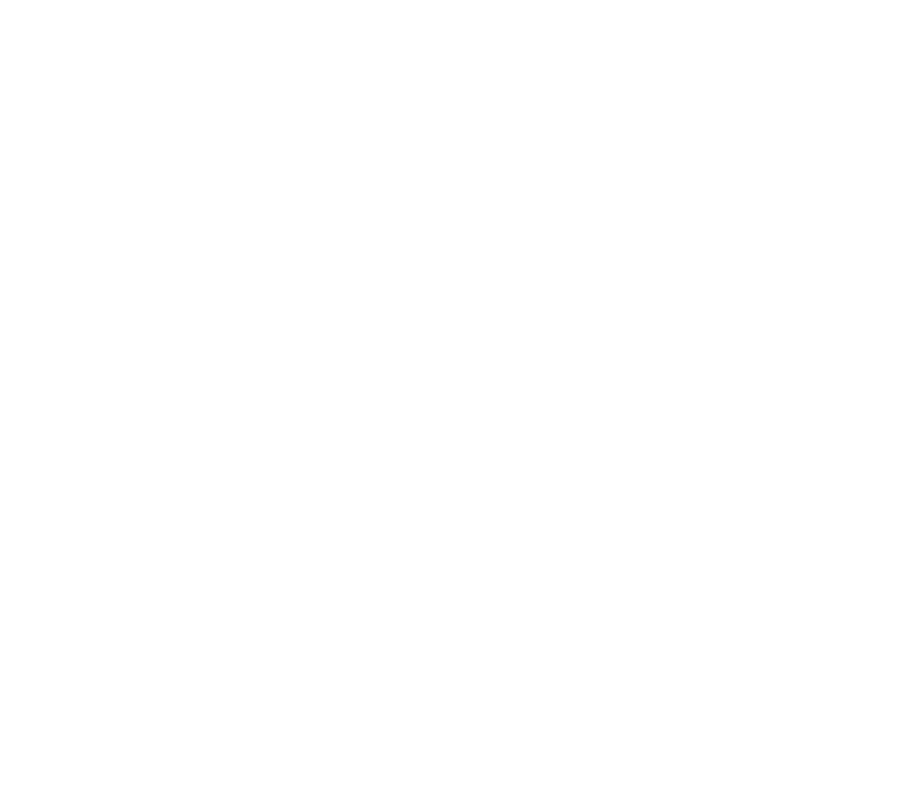

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
INFO:UnstructuredGrid:Warning, boundary_polygon() failed using edges!  Trying polygon union method


<IPython.core.display.Javascript object>


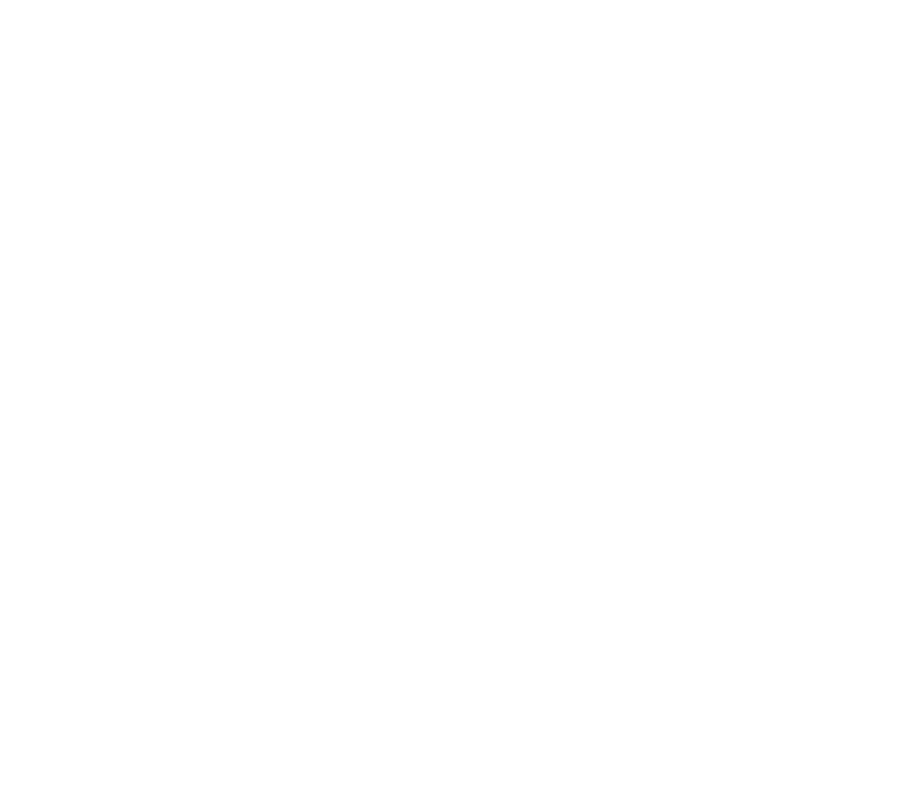

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
INFO:UnstructuredGrid:Warning, boundary_polygon() failed using edges!  Trying polygon union method


<IPython.core.display.Javascript object>


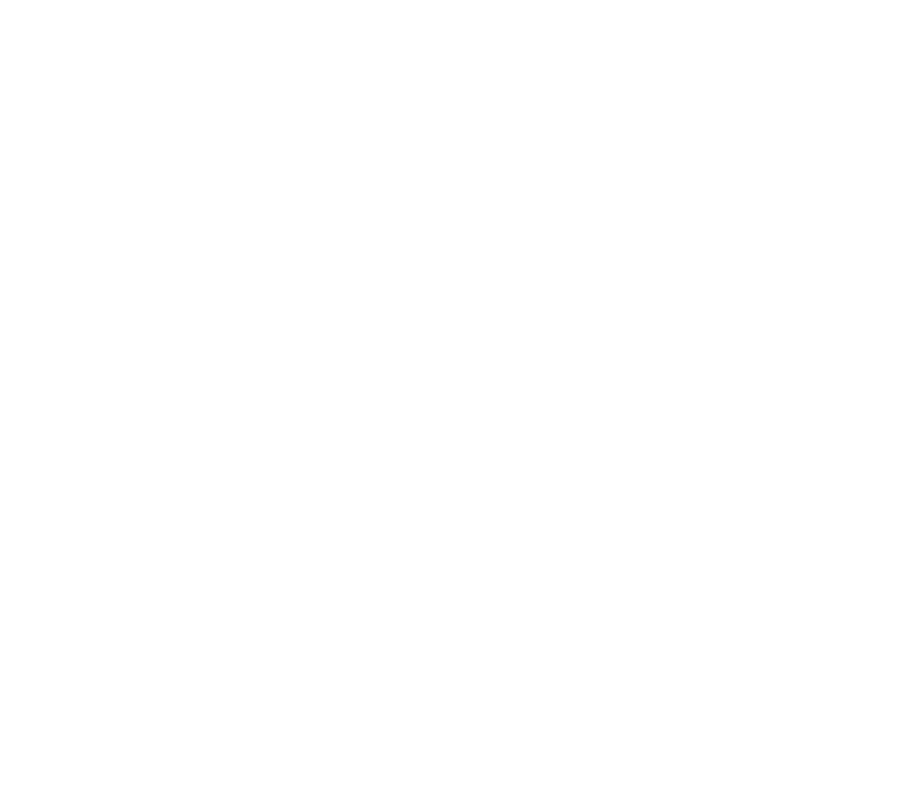

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
INFO:UnstructuredGrid:Warning, boundary_polygon() failed using edges!  Trying polygon union method


<IPython.core.display.Javascript object>


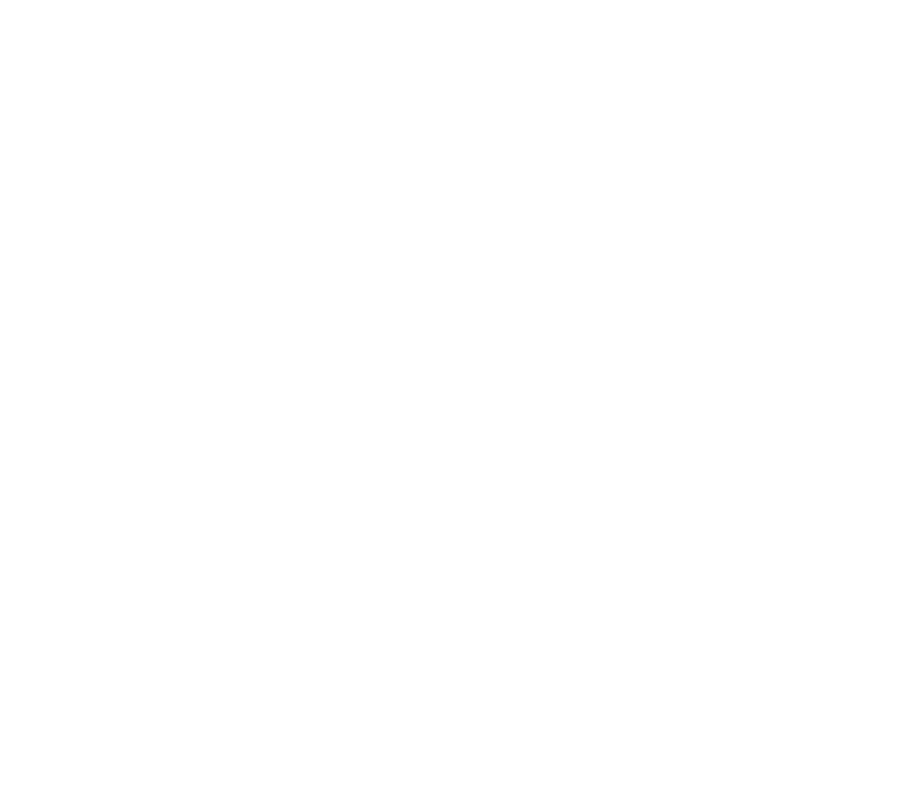

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
INFO:UnstructuredGrid:Warning, boundary_polygon() failed using edges!  Trying polygon union method


<IPython.core.display.Javascript object>


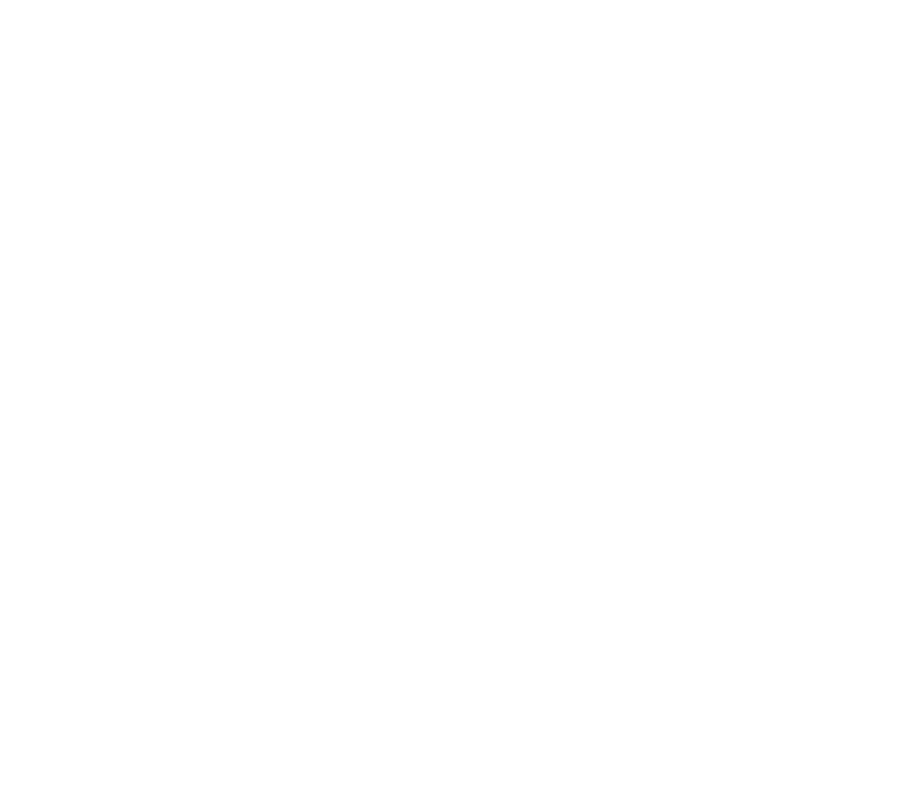

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
INFO:UnstructuredGrid:Warning, boundary_polygon() failed using edges!  Trying polygon union method


<IPython.core.display.Javascript object>


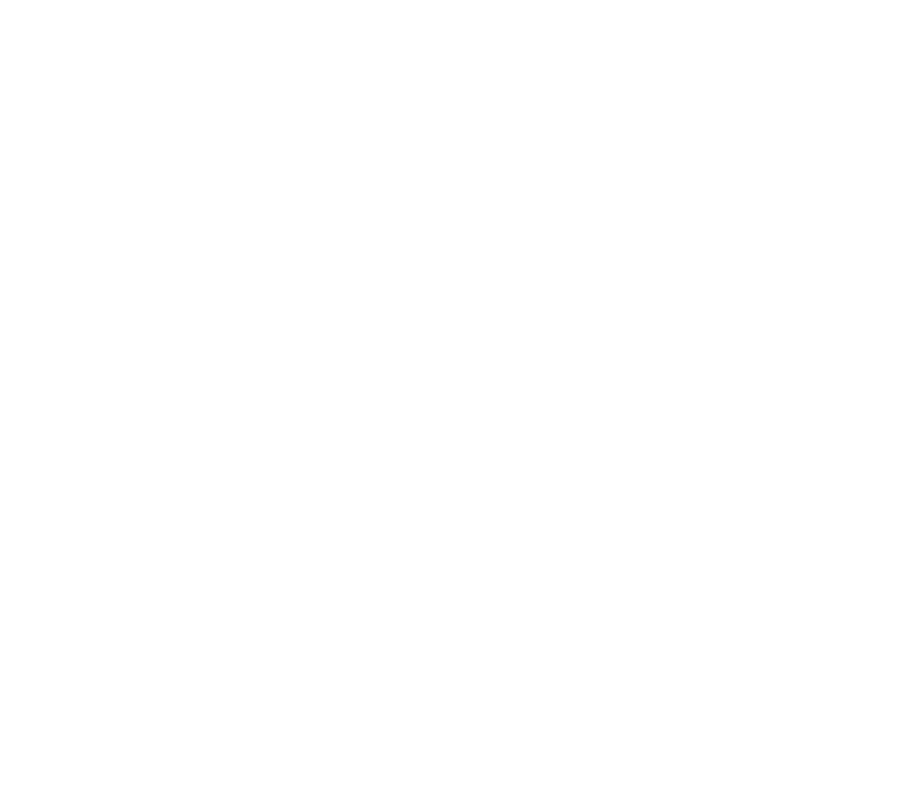

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
INFO:UnstructuredGrid:Warning, boundary_polygon() failed using edges!  Trying polygon union method


<IPython.core.display.Javascript object>


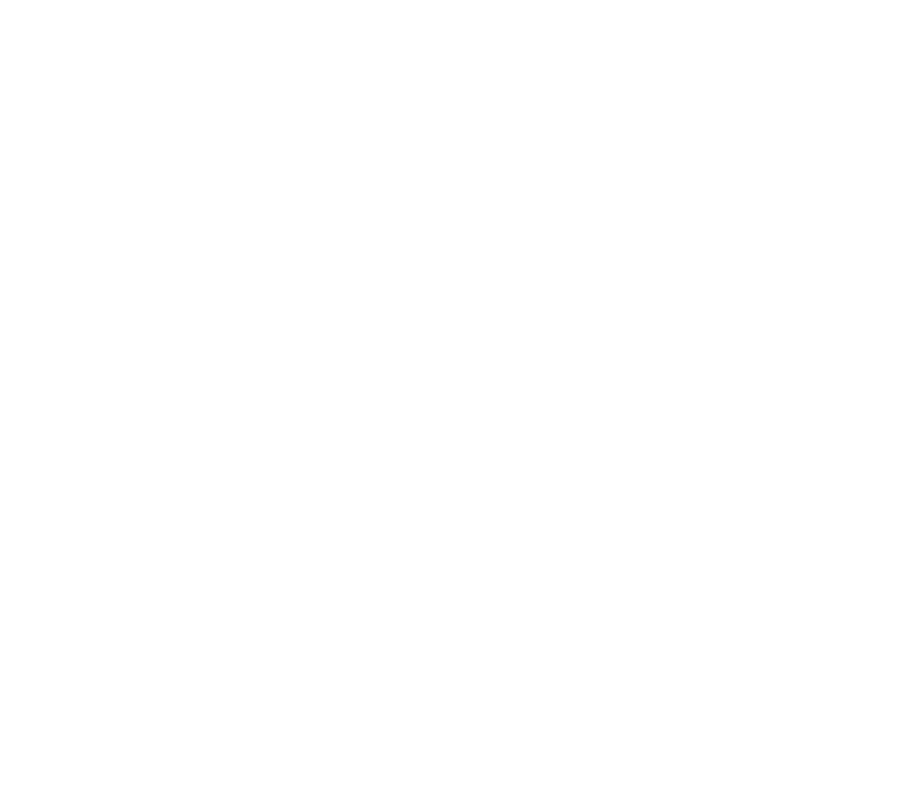

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
INFO:UnstructuredGrid:Warning, boundary_polygon() failed using edges!  Trying polygon union method


<IPython.core.display.Javascript object>


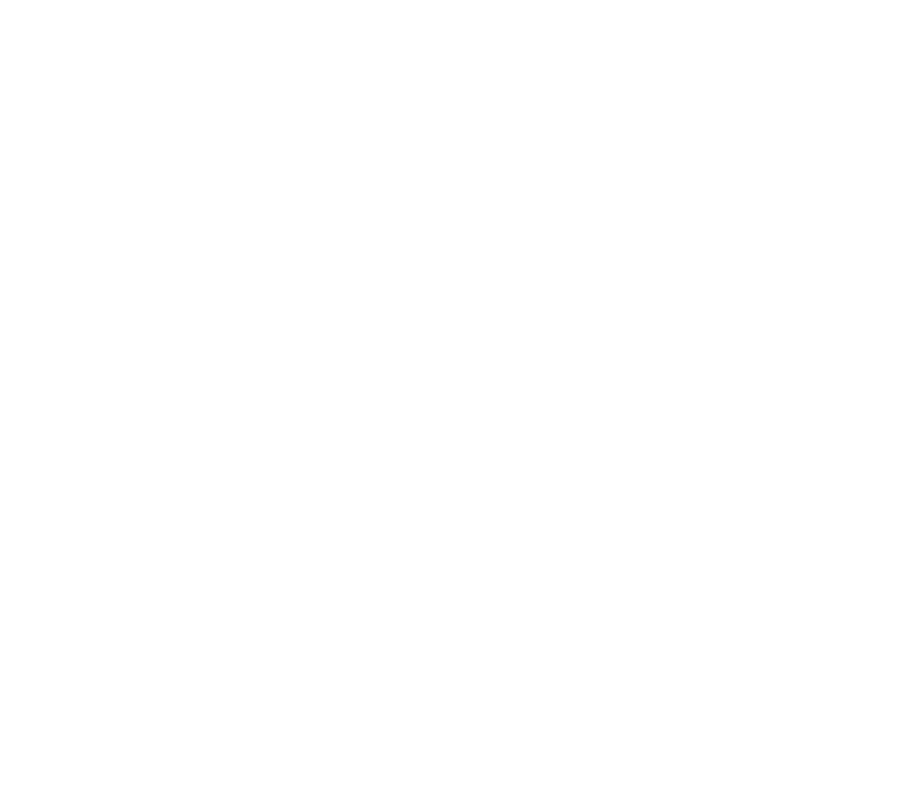

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
INFO:UnstructuredGrid:Warning, boundary_polygon() failed using edges!  Trying polygon union method


<IPython.core.display.Javascript object>


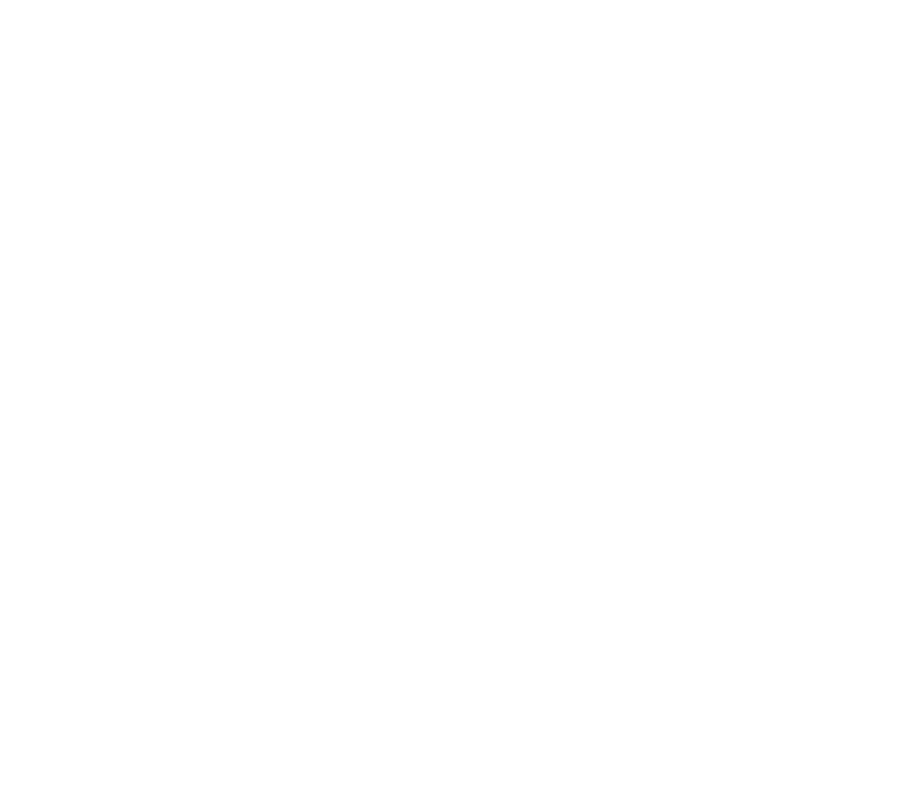

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
INFO:UnstructuredGrid:Warning, boundary_polygon() failed using edges!  Trying polygon union method


<IPython.core.display.Javascript object>


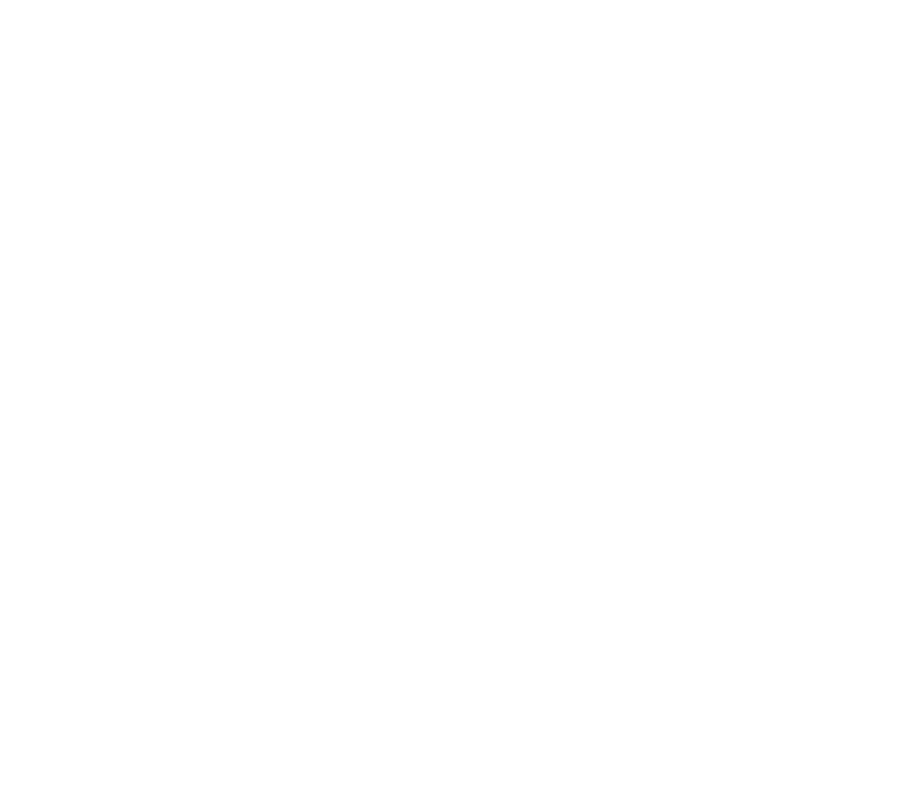

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
INFO:UnstructuredGrid:Warning, boundary_polygon() failed using edges!  Trying polygon union method


<IPython.core.display.Javascript object>


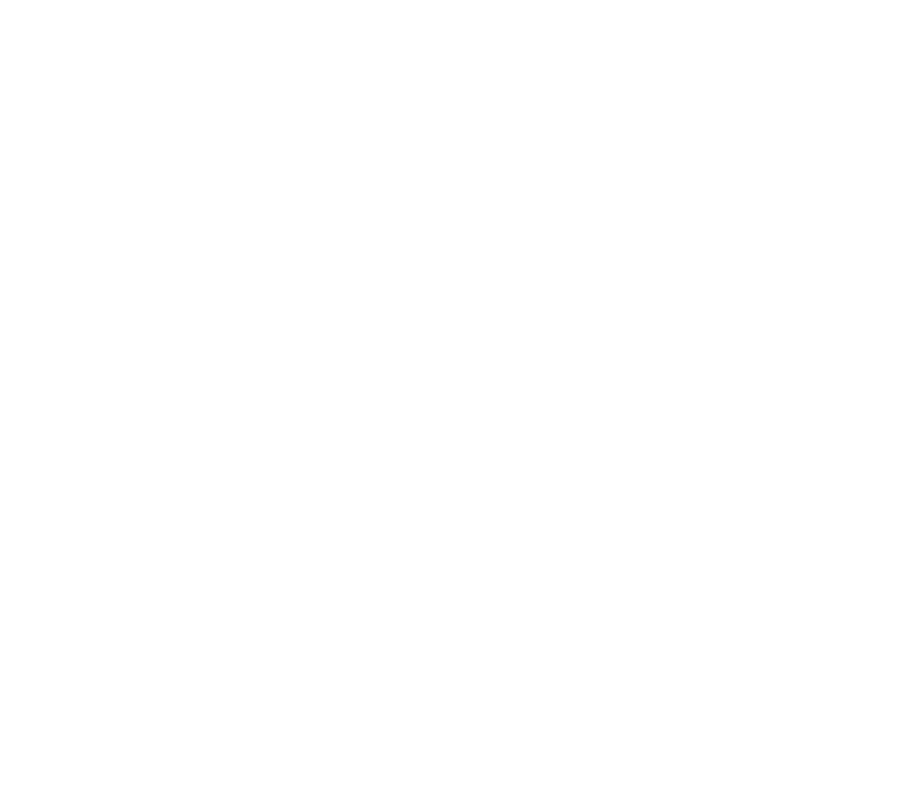

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
INFO:UnstructuredGrid:Warning, boundary_polygon() failed using edges!  Trying polygon union method


<IPython.core.display.Javascript object>


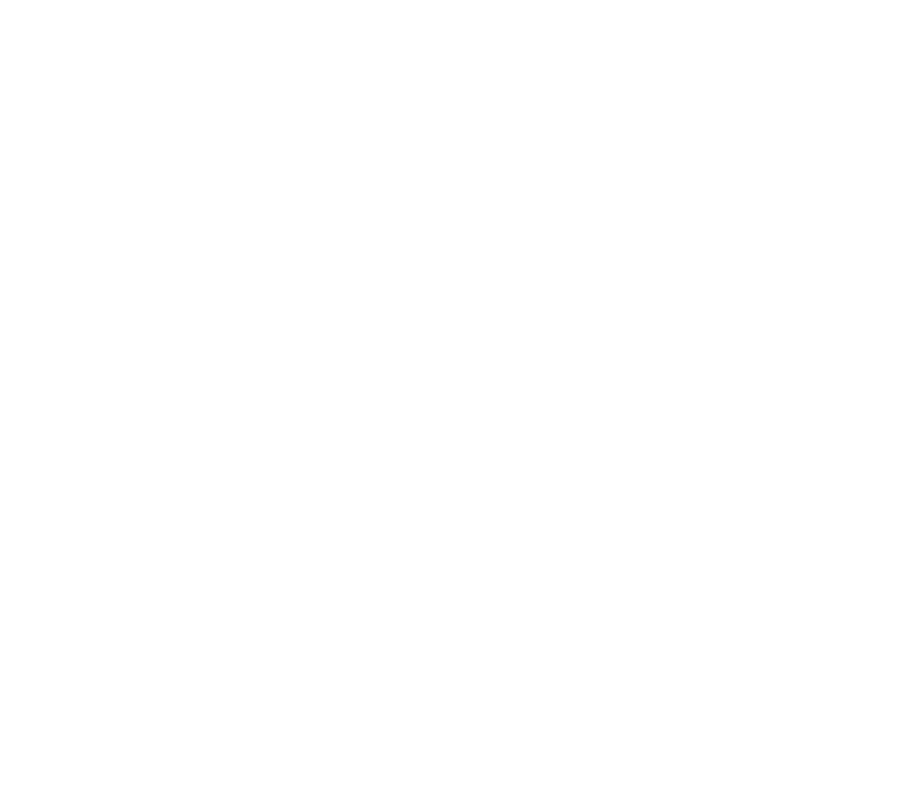

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
INFO:UnstructuredGrid:Warning, boundary_polygon() failed using edges!  Trying polygon union method


<IPython.core.display.Javascript object>


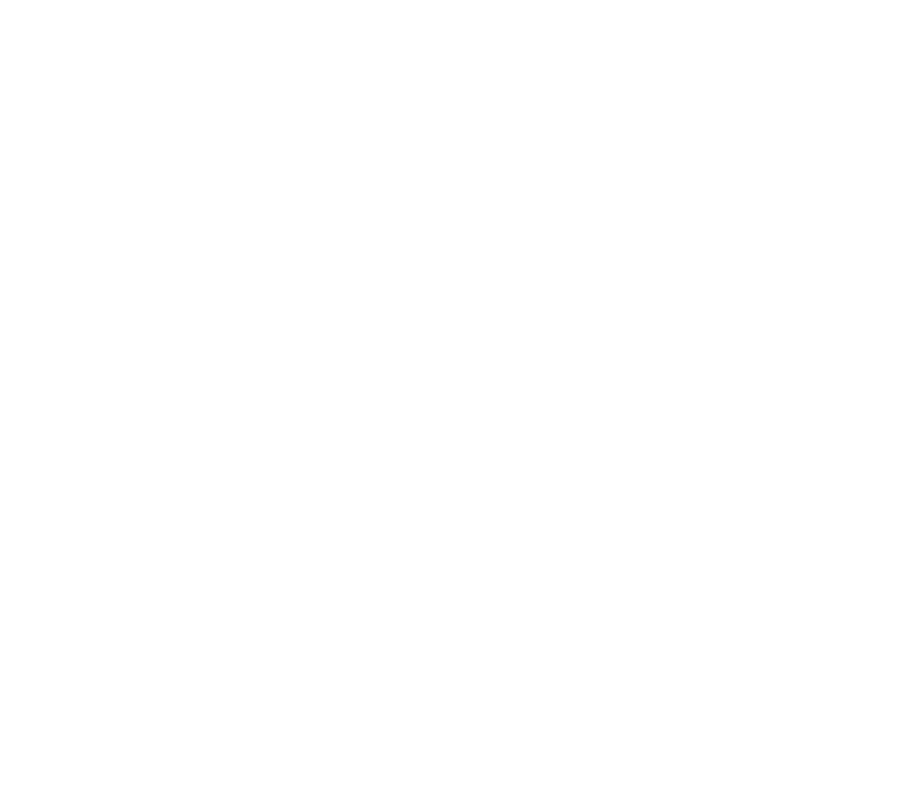

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
INFO:UnstructuredGrid:Warning, boundary_polygon() failed using edges!  Trying polygon union method


<IPython.core.display.Javascript object>


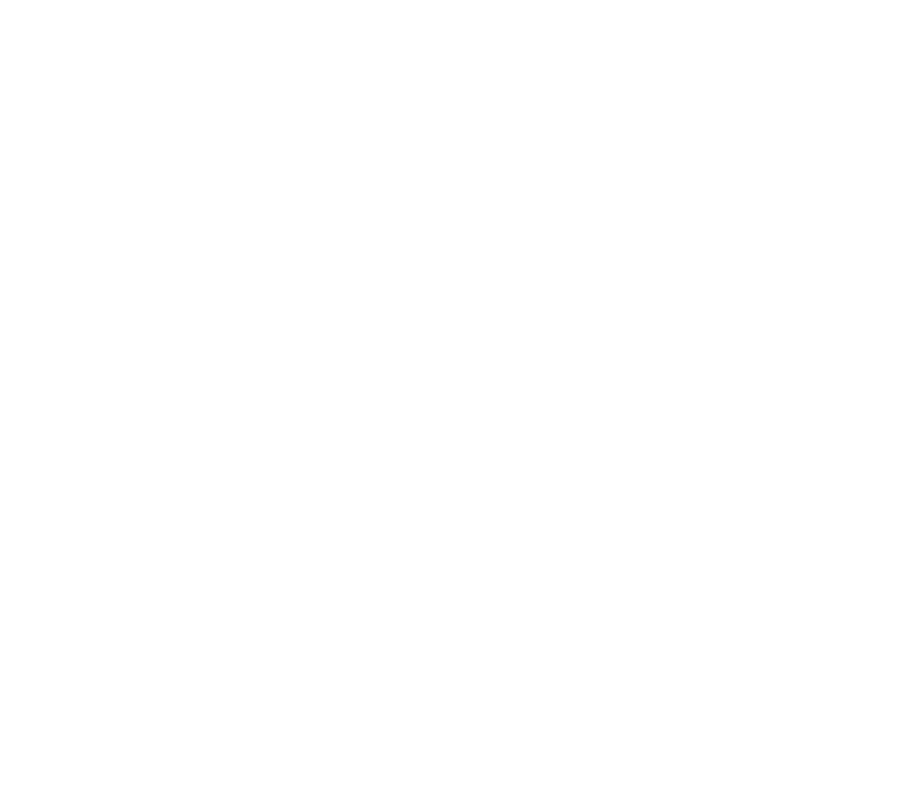

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
INFO:UnstructuredGrid:Warning, boundary_polygon() failed using edges!  Trying polygon union method


In [425]:
for run_dir in run_dirs[1:]:
    model=dfm.DFlowModel.load(run_dir)
    rp=RotoPlot(model)
    t_str=utils.strftime(model.run_start,"%Y%m%dT%H%M")
    fn=os.path.join(roto_dir,f"summary-{t_str}.png")
    rp.fig.savefig(fn,dpi=150)
    plt.close(rp.fig)

Growth Rate Analysis
--

In [426]:
from shapely import wkt
ssfb_wkt="""Polygon ((552701.88427324150688946 4182777.26593696838244796, 557664.74622329045087099 4184715.14536508312448859, 558704.58396520547103137 4181690.16284314822405577, 563052.9963404864538461 4179279.62989598186686635, 564470.95689764339476824 4179232.36454407637938857, 564612.75295335904229432 4177058.15835643606260419, 565888.91745480021927506 4175025.74822451127693057, 569244.75744007143657655 4172662.48062924947589636, 570709.9833491335157305 4173324.19555592304095626, 574254.88474202563520521 4169873.82486684108152986, 575483.78389156155753881 4162122.30715438397601247, 576759.94839300273451954 4157490.3026676713488996, 578934.15458064316771924 4153898.13592287385836244, 574396.68079774128273129 4150022.37706664530560374, 570520.92194151261355728 4154323.52409002091735601, 565794.38675098970998079 4157726.62942719738930464, 561540.50507951923646033 4158908.2632248280569911, 556152.2549623231170699 4160420.75448579574003816, 553741.72201515652704984 4163209.41024820413440466, 553316.33384800946805626 4168314.06825396884232759, 552701.88427324150688946 4182777.26593696838244796))"""
ssfb_poly=wkt.loads(ssfb_wkt)

In [427]:
# 8/16 to 8/17 looks like a decent one to test with.
model=dfm.DFlowModel.load(run_dirs[13])
shore_poly=model.grid.boundary_polygon()

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
INFO:UnstructuredGrid:Warning, boundary_polygon() failed using edges!  Trying polygon union method


In [459]:
from matplotlib import colors
from scipy.interpolate import griddata
def safe_ratio(num,den,clip=100):
    """
    Ratio of ill-behaved values.
    result is if
     - ratio would be greater than clip or less than 1/clip.
    """
    valid = (clip*den>=num) & (clip*num>=den)
    result=np.zeros_like(num)
    result[valid] = num[valid]/den[valid]
    result[~valid] = np.nan
    return result

class RotoGrowth:
    zoom=(529348.6949125907, 577019.3517870362, 4156965.4523581555, 4192441.2900321614)
    uniform_var=None
    weight_var="weight0"
    weight_value_var="wvalue0"
    layer_kw=dict(laydim=-1) # dfm surface
    normalize="layer" # "davg"
    chl_clim=[0,100]
    clip_poly=ssfb_poly
    map_ds=None

    def __init__(self,model,**kw):
        utils.set_keywords(self,kw)
        if self.map_ds is None: # could have been passed in.
            self.map_ds=model.map_dataset()        

        # Top row: 
        # IC, model result, RS result. delta.
        self.set_state()

    def set_state(self):
        # time interval in days
        self.dt_d=(self.map_ds.time.values[-1]-self.map_ds.time.values[0])/np.timedelta64(1,'D')
        # text labels for start/end times
        self.t0=utils.strftime(self.map_ds.time.values[0],"%Y-%m-%d %H:%M")
        self.tN=utils.strftime(self.map_ds.time.values[-1],"%Y-%m-%d %H:%M")

        # Load the start/stop scenes:
        self.tracer_start=self.get_tracer(0)
        self.tracer_stop =self.get_tracer(-1)
        
        self.rs_start = self.get_rs(0)
        self.rs_stop  = self.get_rs(-1)
        self.ratio = safe_ratio(self.rs_stop,self.tracer_stop,clip=100)

        # want the rate that would go into an exponential growth model:
        # dCdt = kC
        # C=C0*exp(k*t)
        # k=np.log(C/C0) / t
        self.net_growth=np.log(self.ratio)/self.dt_d 
        
    def fig_panels(self):
        fig,axs=plt.subplots(1,4,figsize=(9,4))
        fig.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01,
                            hspace=0.04,wspace=0.08)
        self.fig=fig
        self.axs=axs
        
        for ax in axs.ravel():
            ax.set_adjustable('datalim')
            ax.axis('off')
        
        chl_kw=dict(cmap='turbo',clim=self.chl_clim,edgecolor='face',lw=0.5)
        coll_ic    =map_ds.grid.plot_cells(values=self.tracer_start, ax=axs[0], **chl_kw)
        coll_tracer=map_ds.grid.plot_cells(values=self.tracer_stop, ax=axs[1], **chl_kw)
        coll_rs    =map_ds.grid.plot_cells(values=self.rs_stop, ax=axs[2], **chl_kw)

        axs[0].text(0.01,0.02,f"{self.t0} Tracer",transform=axs[0].transAxes)
        axs[1].text(0.01,0.02,f"{self.tN} Tracer",transform=axs[1].transAxes)
        axs[2].text(0.01,0.02,f"{self.tN} RS",    transform=axs[2].transAxes)
                
        coll_ratio=map_ds.grid.plot_cells(values=self.net_growth, cmap='seismic',
                                          clim=[-2,2],ax=axs[3],
                                          edgecolor='face',lw=0.5)
        plot_wkb.plot_wkb(self.clip_poly,ax=axs[3],fc='none',ec='green',lw=1.0)

        plt.colorbar(coll_ic,    ax=axs[0],label="$\mu$g l$^{-1}$",orientation='horizontal')
        plt.colorbar(coll_tracer,ax=axs[1],label="$\mu$g l$^{-1}$",orientation='horizontal')
        plt.colorbar(coll_rs,    ax=axs[2],label="$\mu$g l$^{-1}$",orientation='horizontal')
        plt.colorbar(coll_ratio, ax=axs[3],label="day$^{-1}$",orientation='horizontal')
        
        for ax in axs[:]:
            plot_wkb.plot_wkb(shore_poly,fc='0.9',ec='none',lw=0.0,zorder=-1,ax=ax)
            plot_wkb.plot_wkb(shore_poly,fc='none',ec='k',lw=0.5,zorder=3,ax=ax)
            ax.axis(self.zoom)
        return fig
            
    min_weight=0.0001
    def get_tracer(self,tidx):
        snap=self.map_ds.isel(time=tidx,**self.layer_kw)
        if self.normalize=='layer':
            weight=snap[self.weight_var].values
        elif self.normalize=='davg':
            weight=(self.map_ds
                    .isel(time=tidx)[self.weight_var]
                    .compute()
                    .mean(dim='laydim').values)
                
        invalid=weight<self.min_weight
        value = snap[self.weight_value_var].values / np.maximum(weight,min_weight)
        value[invalid]=np.nan
        return value

    def get_rs(self,tidx):
        """
        Pick RS scene based on model output time[tidx]. Interpolate to model grid.
        """
        # And the corresponding RS data
        scene_idx=np.searchsorted(scene_df.acquisition_start, self.map_ds.time.values[tidx])
        
        xym=bloom_common.load_scene_utm(scene_df.xml.values[scene_idx],ravel=True)

        xy=np.c_[self.map_ds.FlowElem_xzw.values, self.map_ds.FlowElem_yzw]
        return griddata(xym[:,:2],xym[:,2],xy)
    
    def fig_scatter(self):
        gs=gridspec.GridSpec(2,2)
        fig=plt.figure(figsize=(9,5))
        ax=fig.add_subplot(gs[:,0])
        ax.set_adjustable('datalim')

        valid=np.isfinite(self.tracer_stop)&np.isfinite(self.rs_stop)
        valid = valid
        if 1:
            in_poly=self.map_ds.grid.select_cells_intersecting(self.clip_poly)
            valid=valid & in_poly

        self.valid_samples=valid
        # since we're operating on the grid need to normalize by cell area.
        areas=self.map_ds.grid.cells_area()

        self.sample_weights=areas

        x_max=self.chl_clim[1]
        y_max=2*self.chl_clim[1]

        scat=ax.scatter(self.tracer_stop[valid],
                        self.rs_stop[valid],1.5,self.net_growth[valid])
        scat.set_clim([-1,1])
        scat.set_cmap('turbo')
        ax.set_xlabel('Conservative')
        ax.set_ylabel('RS')
        ax.axis(xmin=0,ymin=0,xmax=self.chl_clim[1],ymax=2*self.chl_clim[1])

        if 1:
            # This is slow.
            # some high outliers will screw up the bandwidth calculation. clip.
            valid_tight=valid & (self.rs_stop<200)
            sns.kdeplot(x=self.tracer_stop[valid_tight],y=self.rs_stop[valid_tight],
                        weights=areas[valid_tight],fill=False,color='k',linewidths=0.8,alpha=0.5,
                        bw_method=0.1,levels=5) 
        if 0:
            h,x_edge,y_edge=np.histogram2d(self.tracer_stop[valid],self.rs_stop[valid],weights=areas[valid],
                                           bins=[np.linspace(0,x_max,200),np.linspace(0,y_max,200)])
            xctr=0.5*(x_edge[1:] + x_edge[:-1])
            yctr=0.5*(y_edge[1:] + y_edge[:-1])
            ax.contour(xctr,yctr,h.T,color='k',linewidths=0.8,alpha=0.5)

        plt.colorbar(scat,label='Net growth (day$^{-1}$)',ax=ax,orientation='horizontal')

        ax_hist=fig.add_subplot(gs[0,1])
        sns.kdeplot(self.net_growth[valid],weights=areas[valid],ax=ax_hist)
        ax_hist.set_xlabel('Net growth rate (day$^{-1}$)')

        ax_txt=fig.add_subplot(gs[1,1])
        ax_txt.axis('off')
        lines=[f"{self.t0} - {self.tN}"]
        ax_txt.text(0.,0.8,"\n".join(lines),va='top')
        fig.subplots_adjust(left=0.07,right=0.97,top=0.97,bottom=0.04)
        return fig
    
class RotoGrowthSeries:
    run_dirs=[]

    zoom=(529348.6949125907, 577019.3517870362, 4156965.4523581555, 4192441.2900321614)
    uniform_var=None
    chl_clim=[0,100]
    clip_poly=ssfb_poly
    ds=None
    
    uniform_var=None
    weight_var="weight0"
    weight_value_var="wvalue0"
    normalize="layer" # "davg"
    
    def __init__(self,**kw):
        utils.set_keywords(self,kw)
        
    def process(self):
        dss=[]

        map_ds=None
        cell_dim='face'
        
        for run_dir in self.run_dirs:
            ds=xr.Dataset()
            ds['run_dir']=(),run_dir

            model=dfm.DFlowModel.load(run_dir)

            if map_ds is None:
                map_ds=model.map_dataset()
            else:
                map_ds.close() # I think it's safe to close at this point.
                map_ds=model.map_dataset(clone_from=map_ds)
                
            rg=RotoGrowth(model,map_ds=map_ds,
                          uniform_var=self.uniform_var,
                          weight_var=self.weight_var,
                          weight_value_var=self.weight_value_var,
                          normalize=self.normalize)
            
            ds['dt']=(),rg.dt_d*np.timedelta64(86400,'s')
            ds['run_start']=(),rg.map_ds.time.values[0]
            ds['run_stop']=(),rg.map_ds.time.values[-1]

            #ds['tracer_start']= ('nFlowElem',),rg.tracer_start
            #ds['tracer_stop'] = ('nFlowElem',),rg.tracer_stop
        
            #ds['rs_start'] = (cell_dim,),rg.rs_start
            ds['rs_stop'] = (cell_dim,), rg.rs_stop
            ds['net_growth']= (cell_dim,), rg.net_growth
            dss.append(ds)

        ds=map_ds.grid.write_xarray(face_dimension=cell_dim)
        ds_data=xr.concat(dss,dim='scene')
        ds=xr.merge([ds,ds_data])
        
        # setting these as coords makes life easier when pulling a single variable
        # out later.
        ds=ds.set_coords(['run_stop','run_start','dt'])
        return ds

    # How histograms are scaled.
    # This option makes them all have the same area
    # dens_scale=0.3
    # density=True
    # This way it's more obvious which days have small sample sizes.
    dens_scale=2e-8
    density=False

    def plot_agg_growth(self):
        grid=unstructured_grid.UnstructuredGrid.read_ugrid(self.ds)
        in_poly=grid.select_cells_intersecting(self.clip_poly)
        ng_select=self.ds.net_growth.isel(face=in_poly)

        x,y = xr.broadcast( ng_select.run_stop, ng_select)
        areas=grid.cells_area()[in_poly]

        bins=np.linspace(-1,1.5,50)

        fig,ax=plt.subplots()
        ax.xaxis.axis_date()

        medians=[]
        for scene in range(self.ds.dims['scene']):
            t=ng_select.run_stop.isel(scene=scene).values
            dnum=dates.date2num(t)
            values=ng_select.isel(scene=scene).values
            valid=np.isfinite(values)
            dens,_ = np.histogram(values[valid],bins=bins,density=self.density,weights=areas[valid])
            ax.stairs(dnum+self.dens_scale*dens, bins, orientation='horizontal',baseline=dnum,fill=True)
            medians.append( [dnum,utils.weighted_median(values[valid],areas[valid])] )

        medians=np.array(medians)

        ax.plot(medians[:,0],medians[:,1],'k-o')
        fig.autofmt_xdate()
        ax.set_ylabel('Net growth rate (d$^{-1}$)')
        fig.subplots_adjust(left=0.07,bottom=0.14,right=0.97,top=0.97)
        ax.grid(1,axis='y')
               
#rg=RotoGrowth(model)
#rg.fig_panels()
#rg.fig_scatter()
#;

<IPython.core.display.Javascript object>


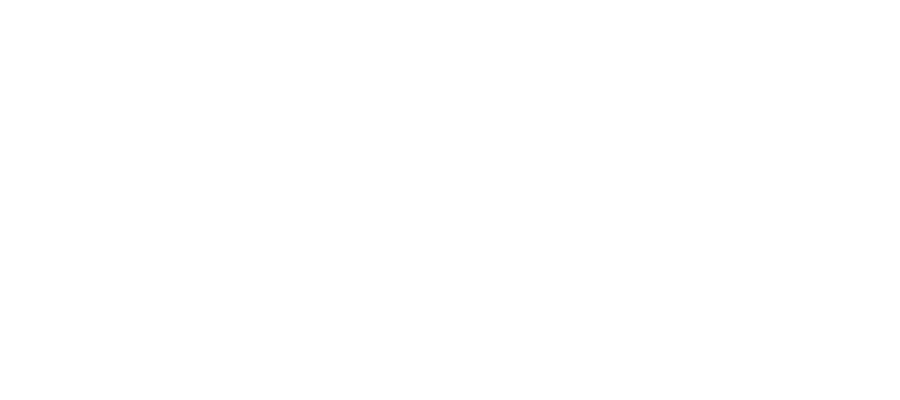

<IPython.core.display.Javascript object>


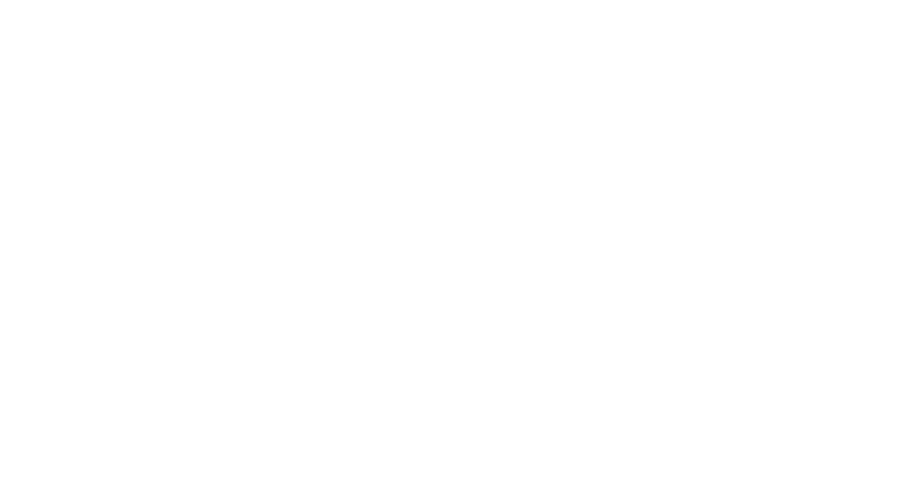

<IPython.core.display.Javascript object>


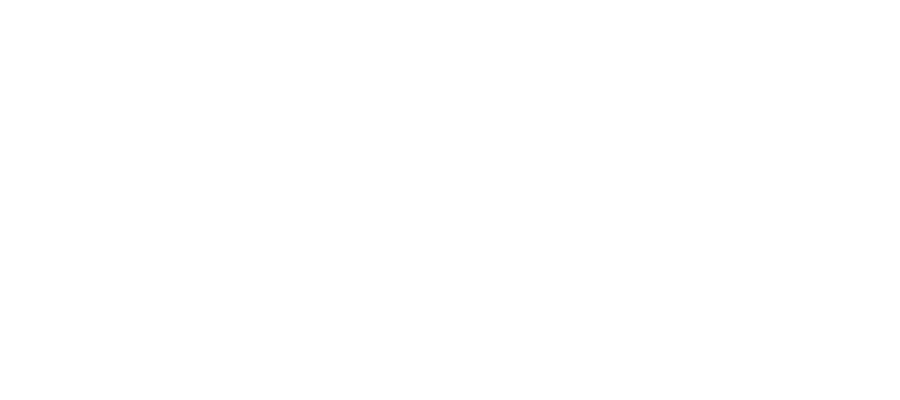

<IPython.core.display.Javascript object>


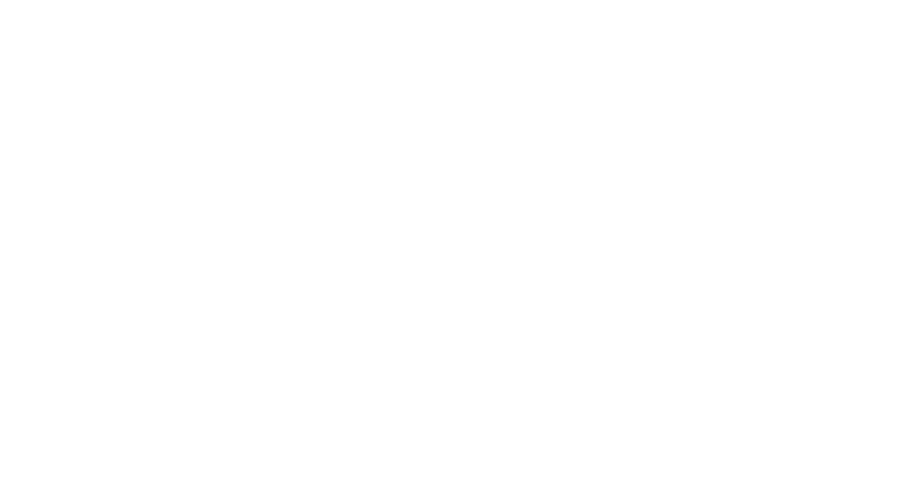

<IPython.core.display.Javascript object>


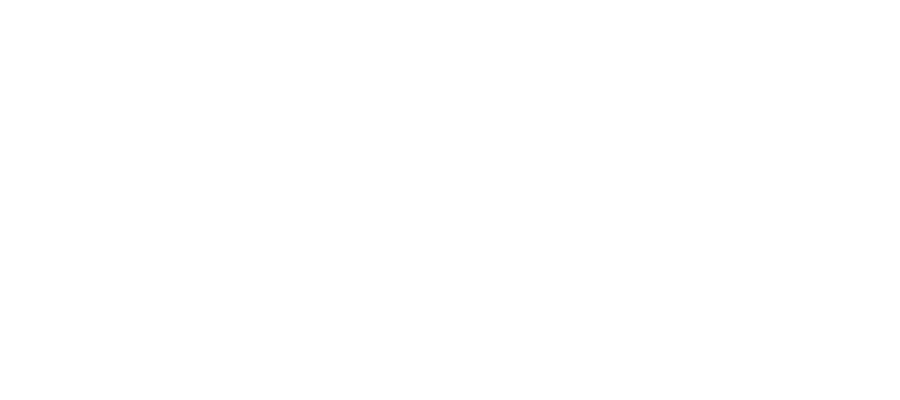

<IPython.core.display.Javascript object>


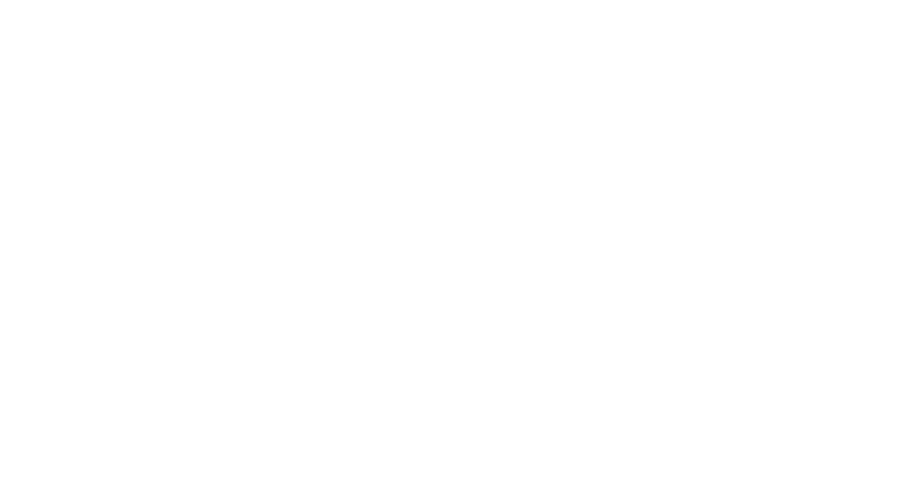

<IPython.core.display.Javascript object>


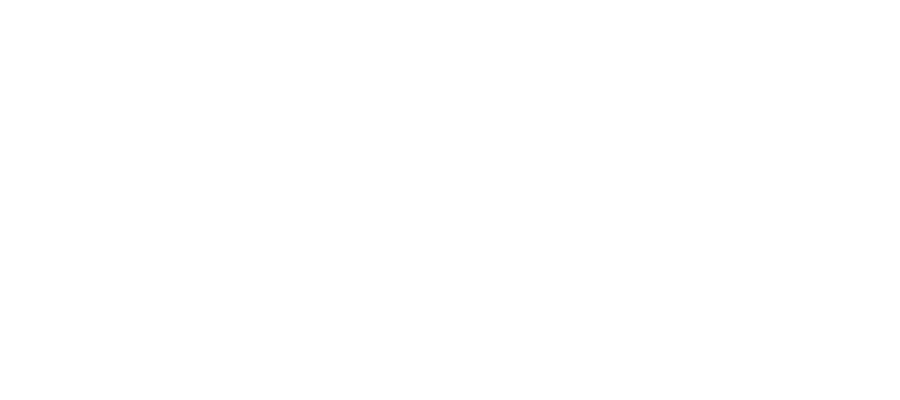

<IPython.core.display.Javascript object>


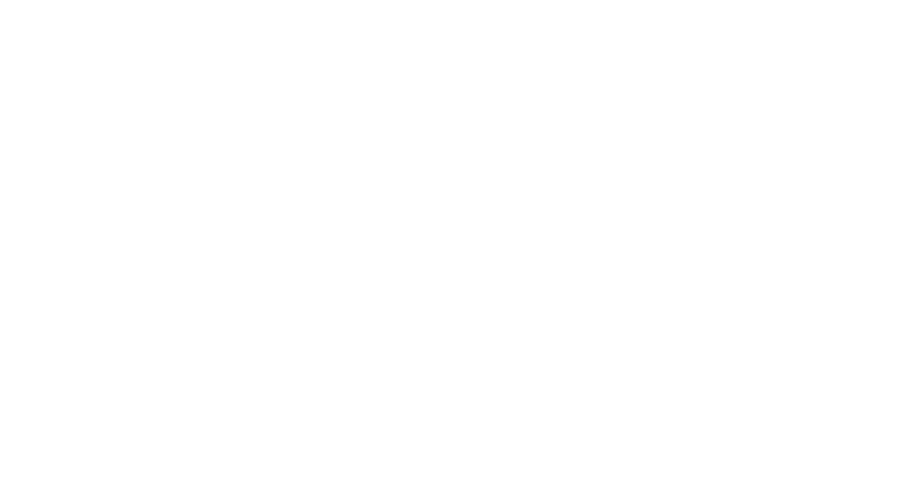

<IPython.core.display.Javascript object>


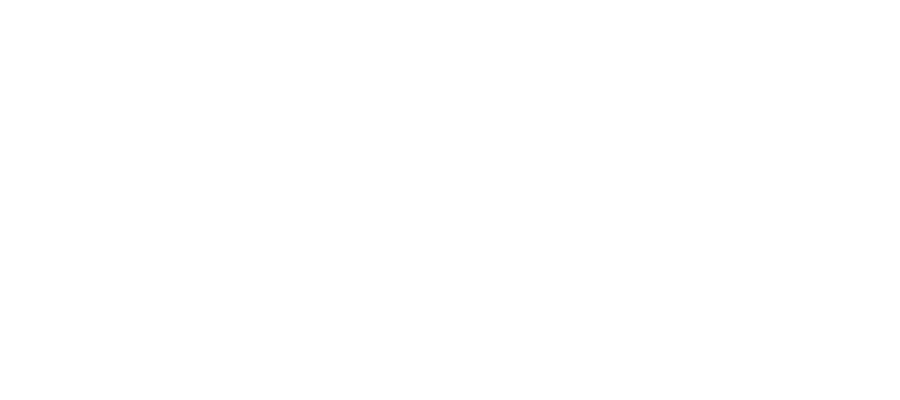

<IPython.core.display.Javascript object>


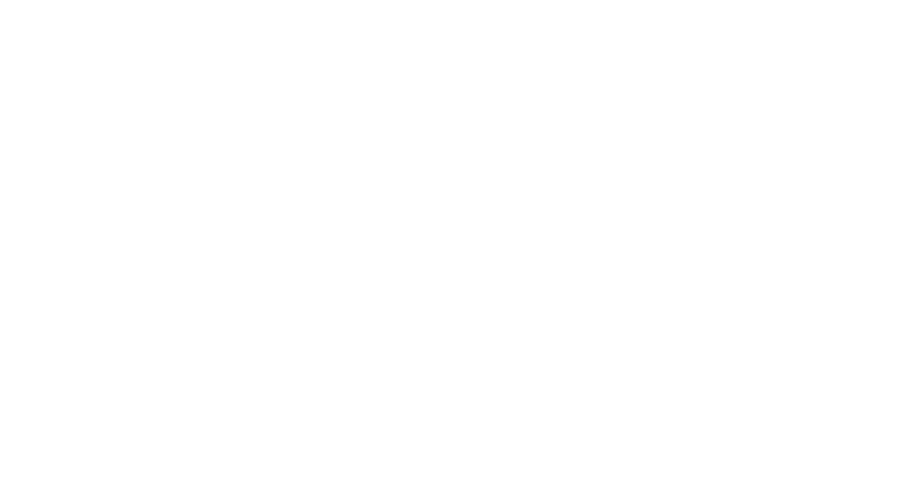

<IPython.core.display.Javascript object>


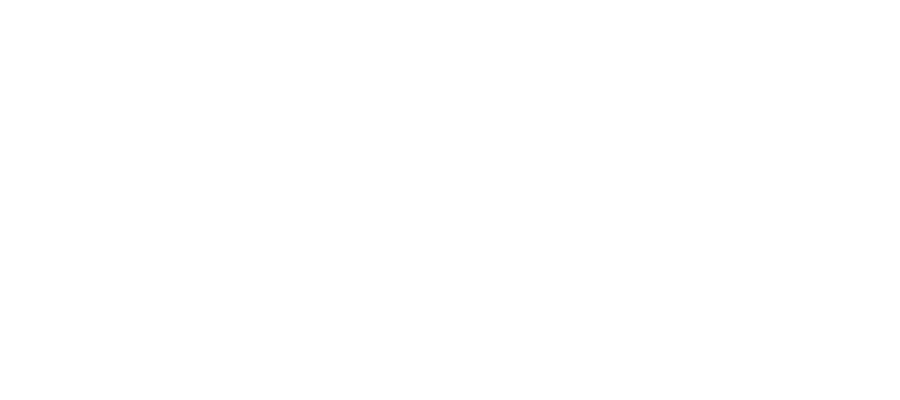

<IPython.core.display.Javascript object>


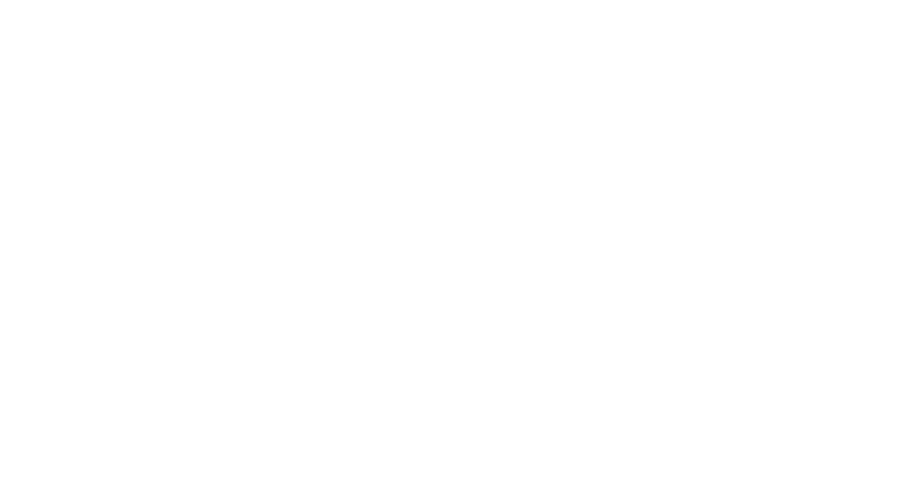

<IPython.core.display.Javascript object>


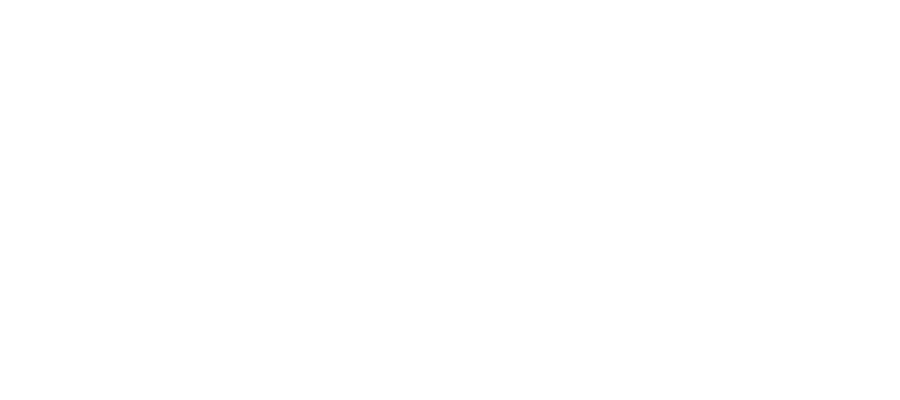

<IPython.core.display.Javascript object>


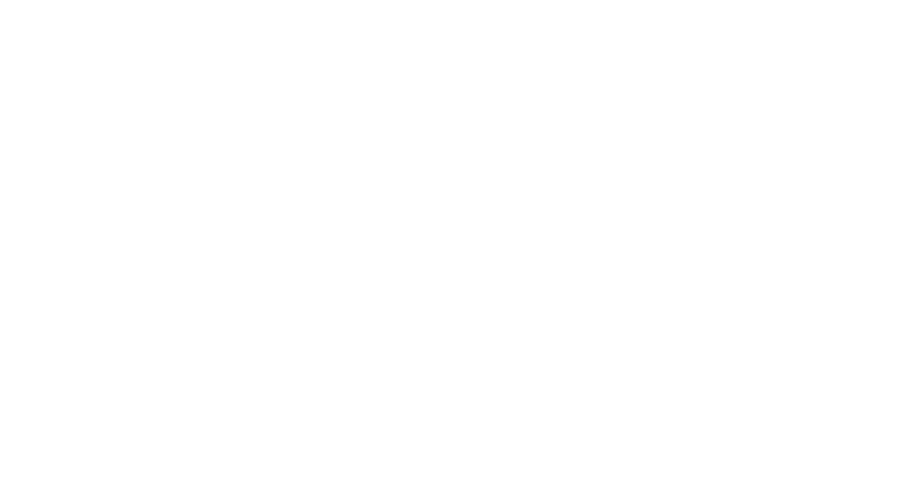

<IPython.core.display.Javascript object>


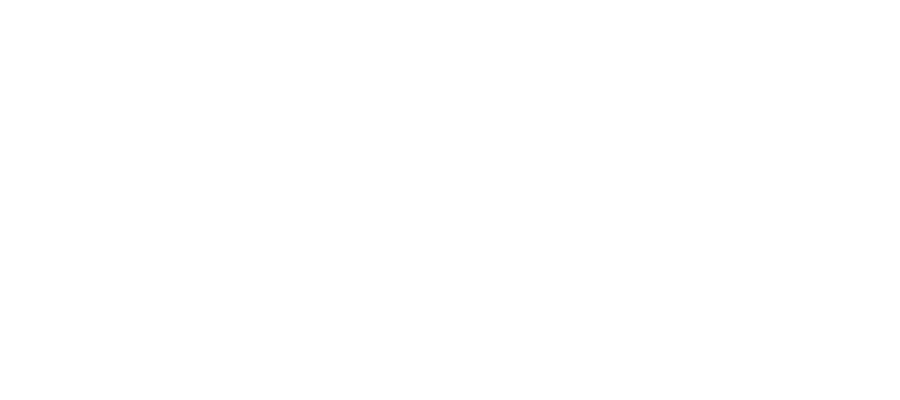

<IPython.core.display.Javascript object>


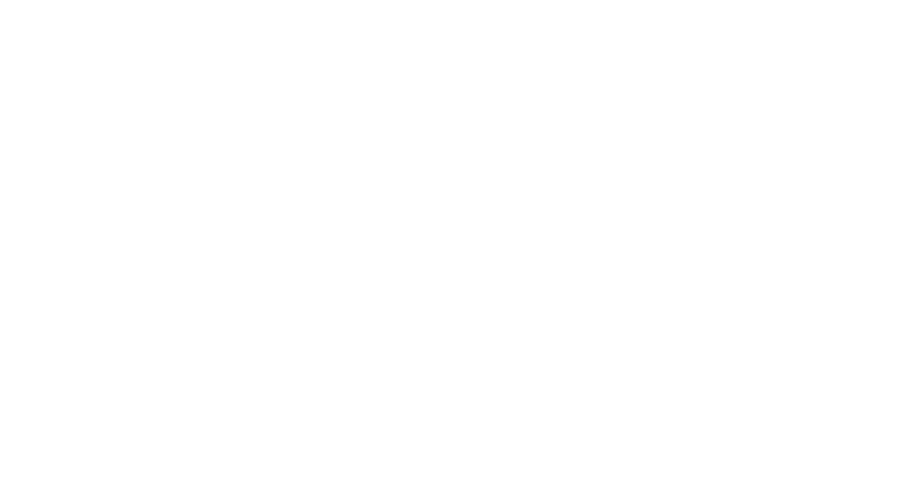

<IPython.core.display.Javascript object>


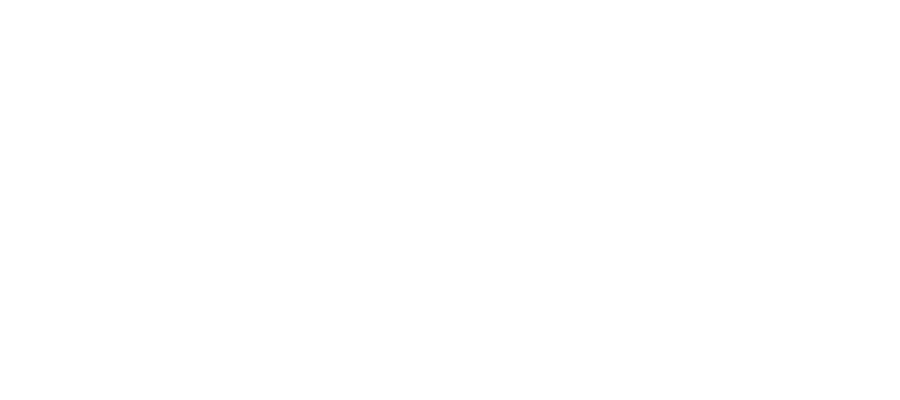

<IPython.core.display.Javascript object>


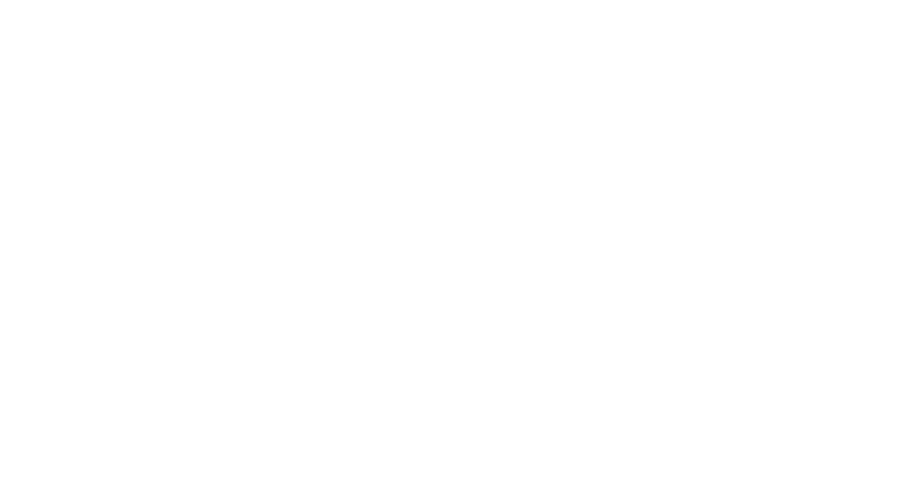

<IPython.core.display.Javascript object>


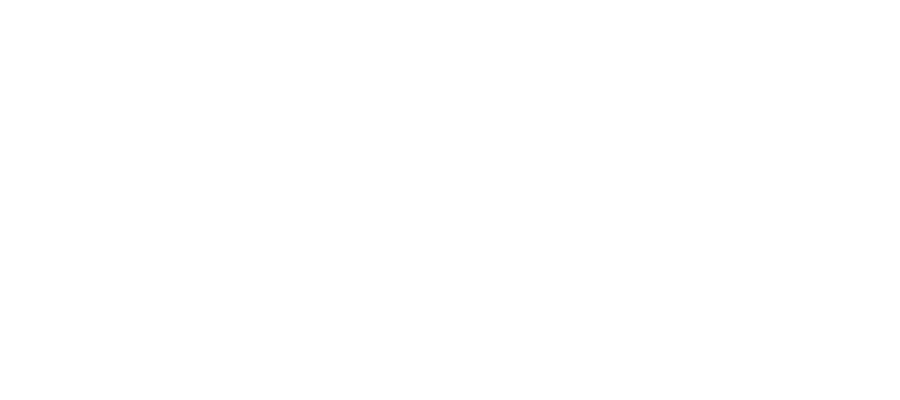

<IPython.core.display.Javascript object>


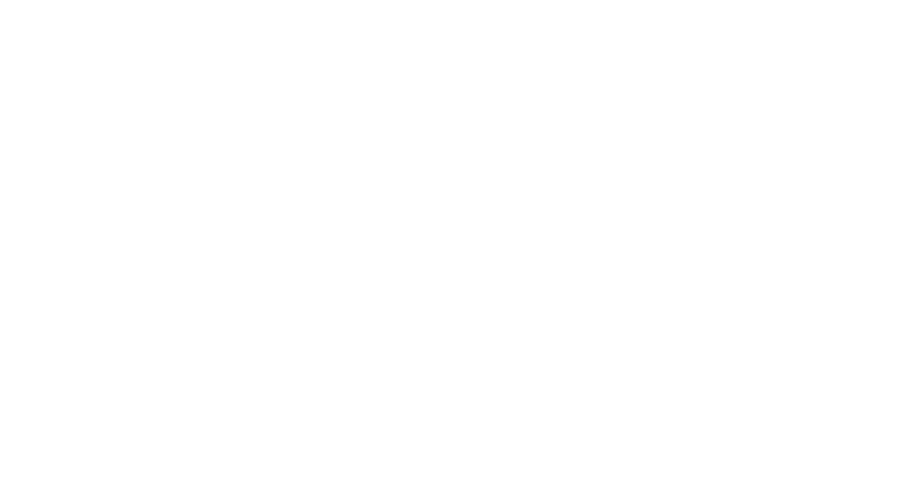

<IPython.core.display.Javascript object>


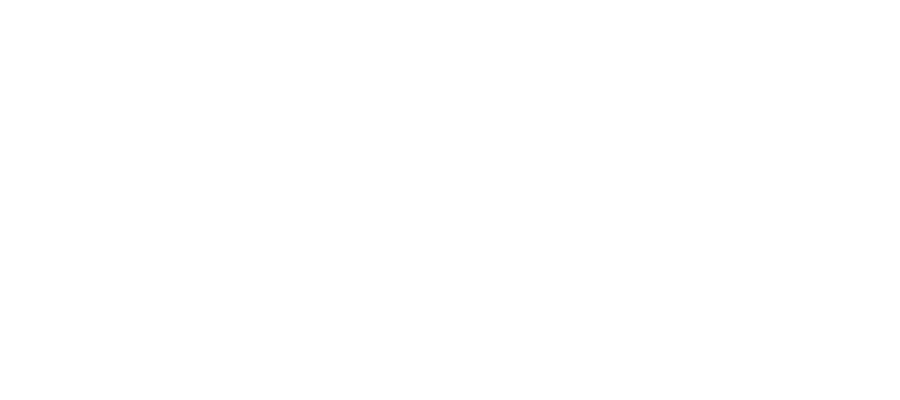

<IPython.core.display.Javascript object>


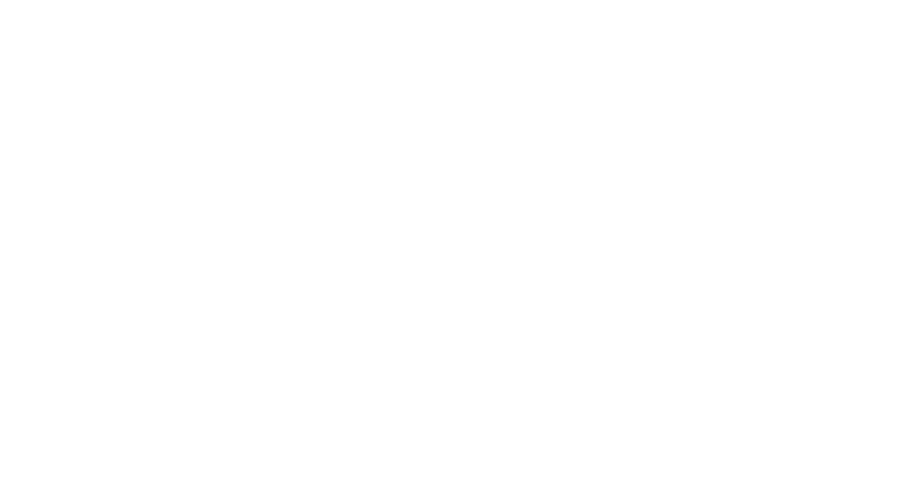

<IPython.core.display.Javascript object>


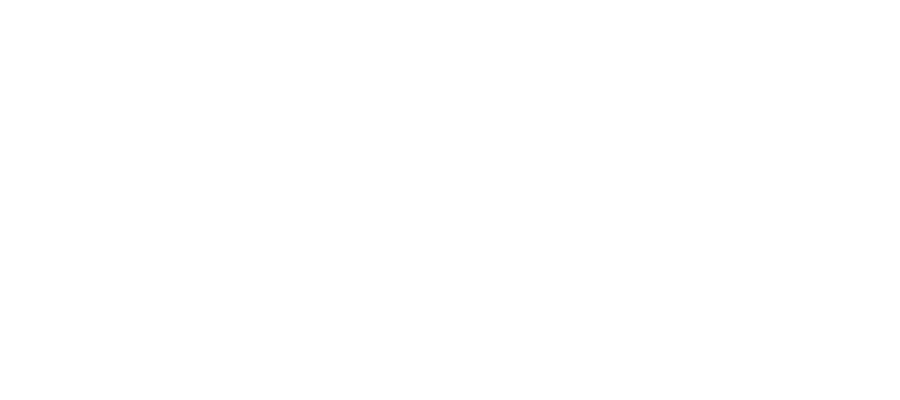

<IPython.core.display.Javascript object>


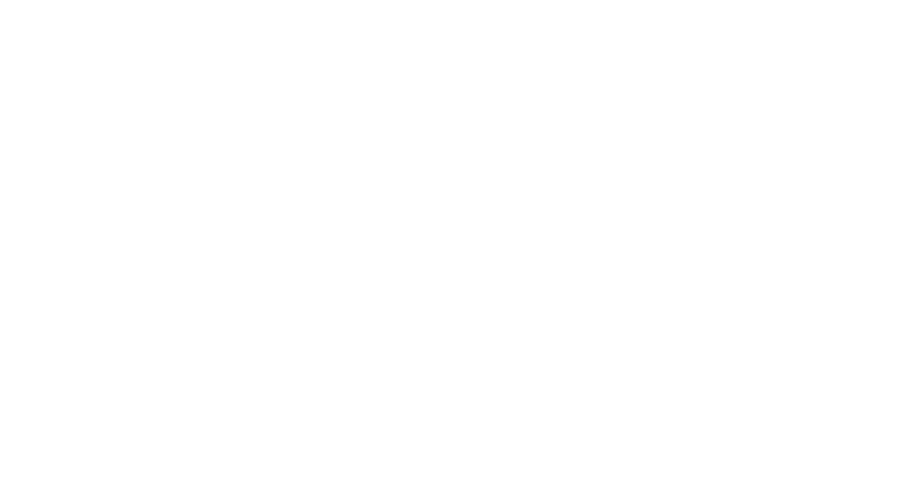

<IPython.core.display.Javascript object>


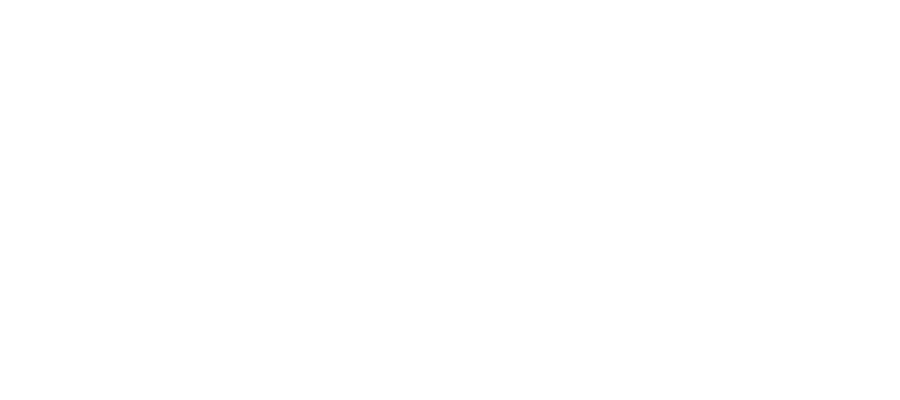

<IPython.core.display.Javascript object>


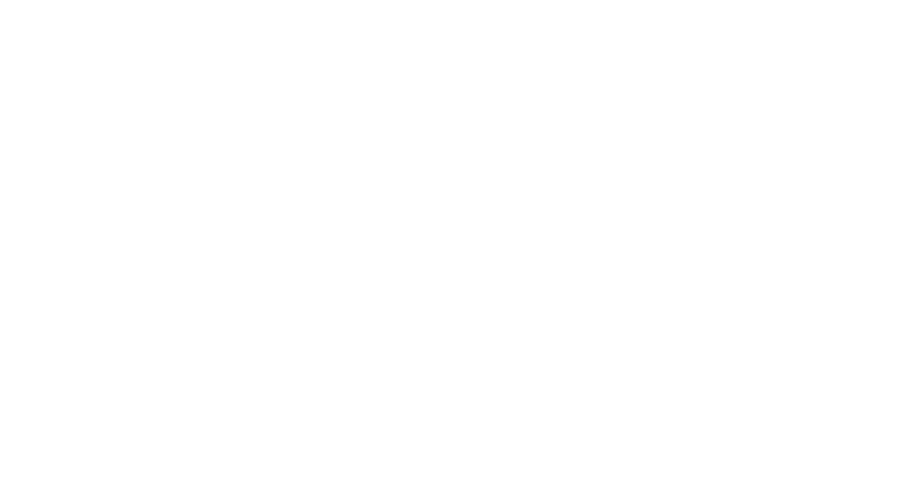

<IPython.core.display.Javascript object>


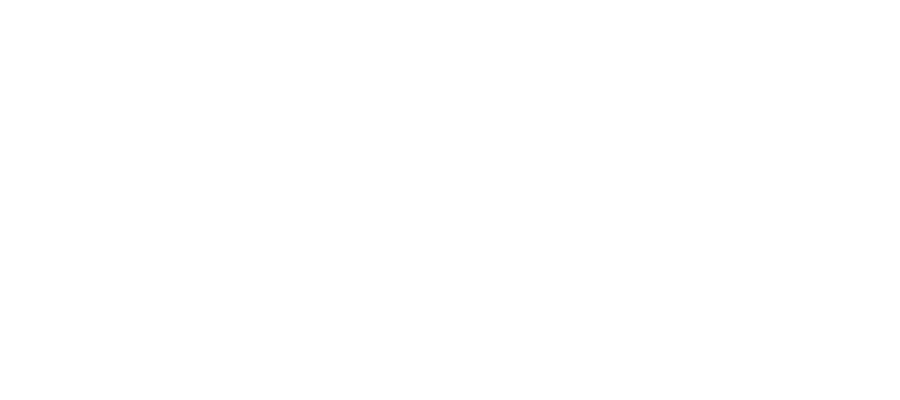

<IPython.core.display.Javascript object>


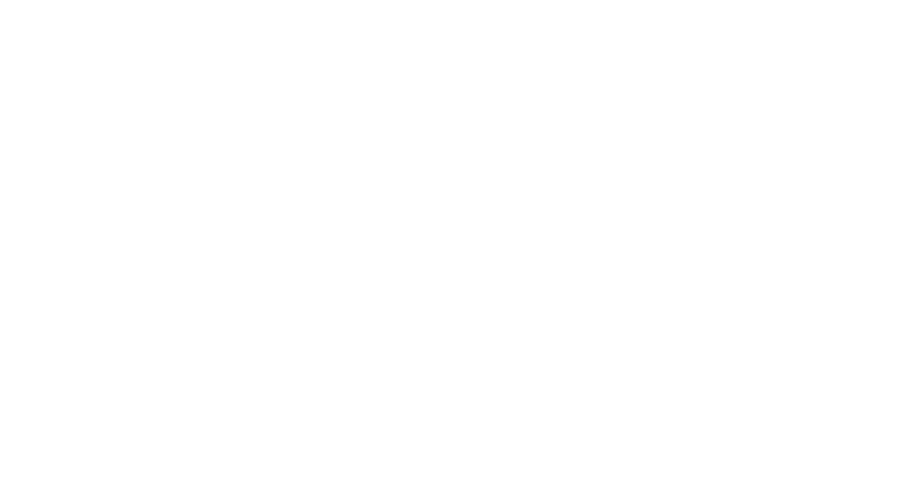

<IPython.core.display.Javascript object>


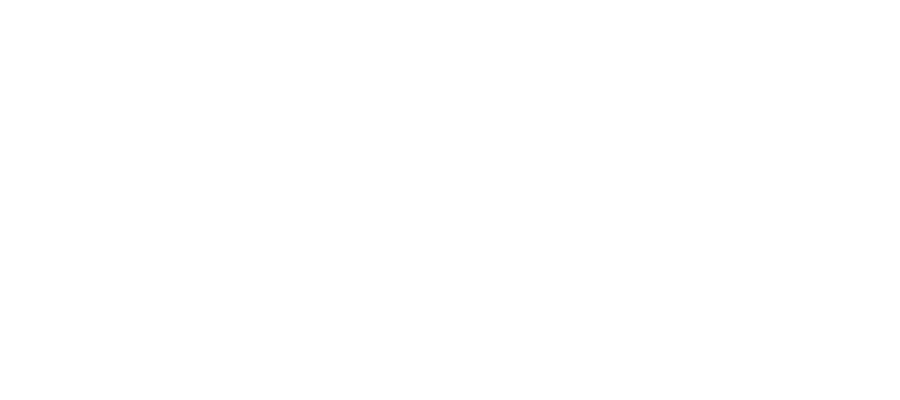

<IPython.core.display.Javascript object>


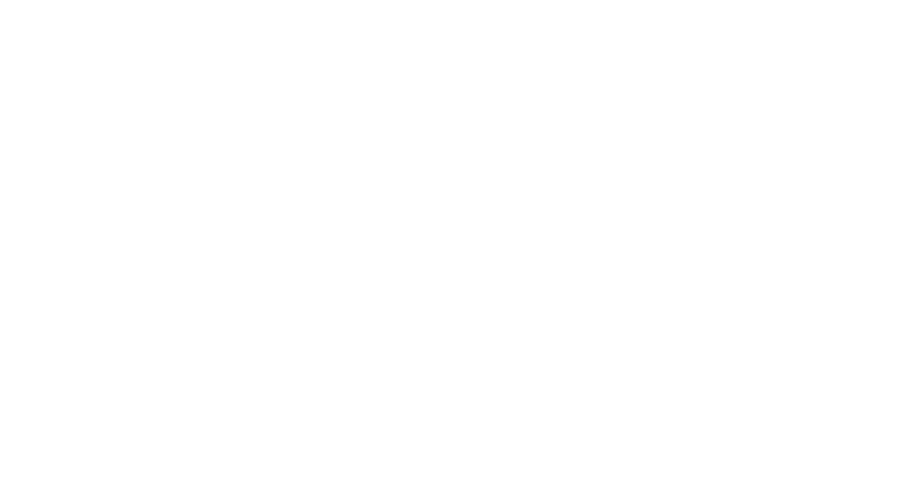

<IPython.core.display.Javascript object>


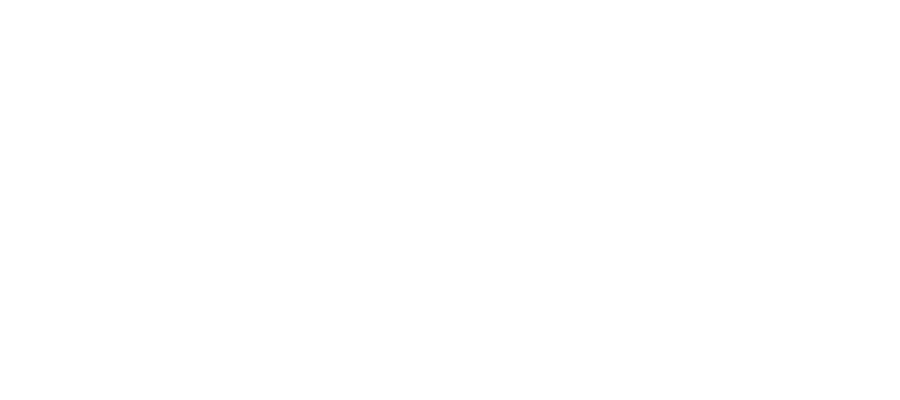

<IPython.core.display.Javascript object>


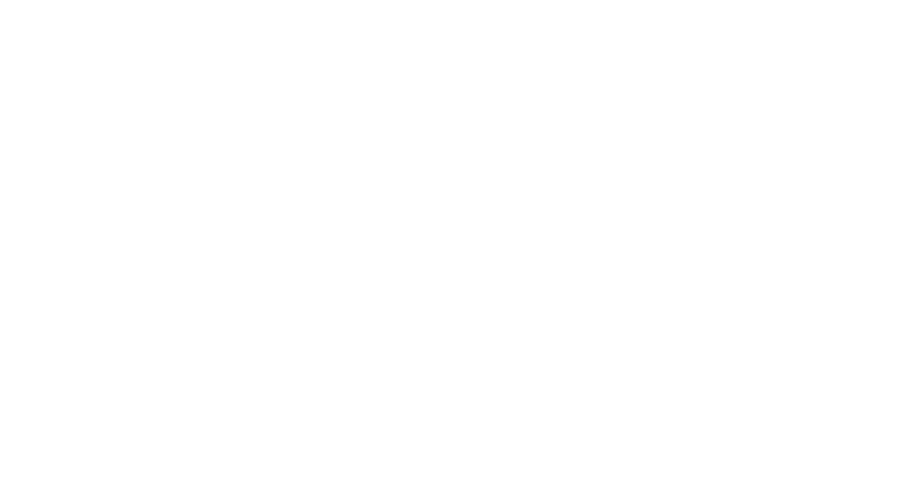

<IPython.core.display.Javascript object>


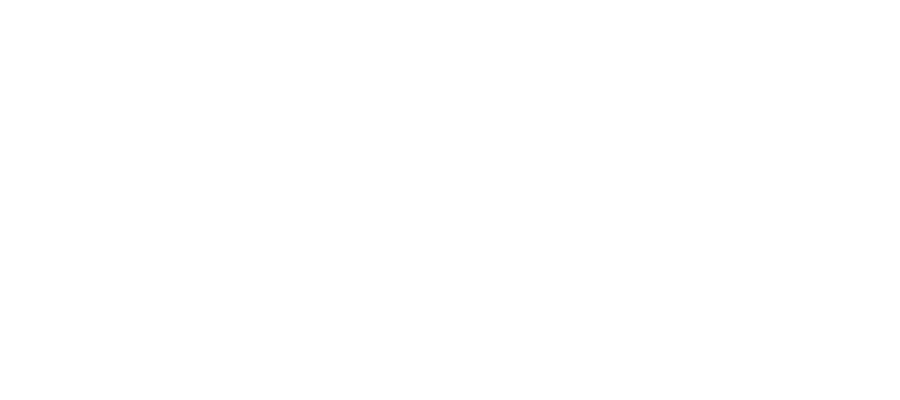

<IPython.core.display.Javascript object>


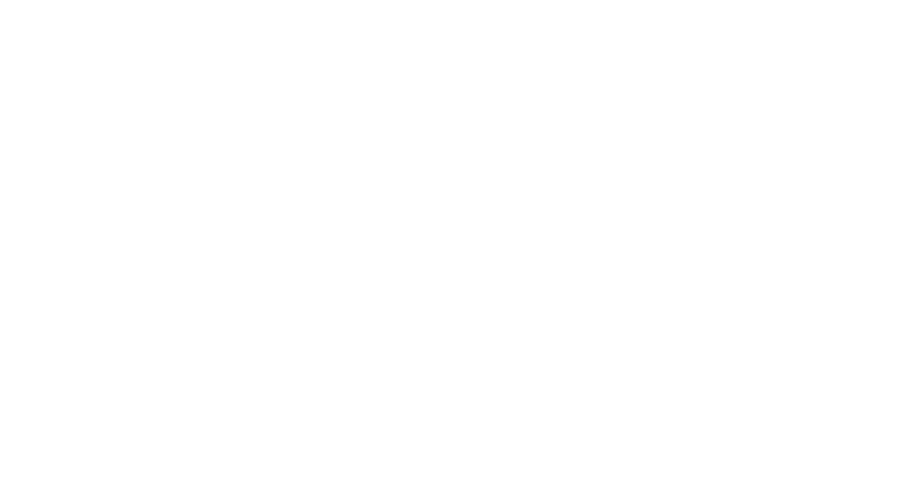

<IPython.core.display.Javascript object>


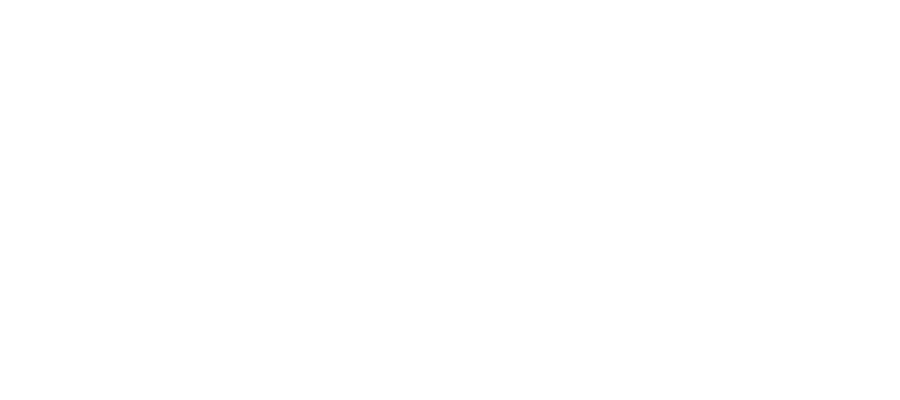

<IPython.core.display.Javascript object>


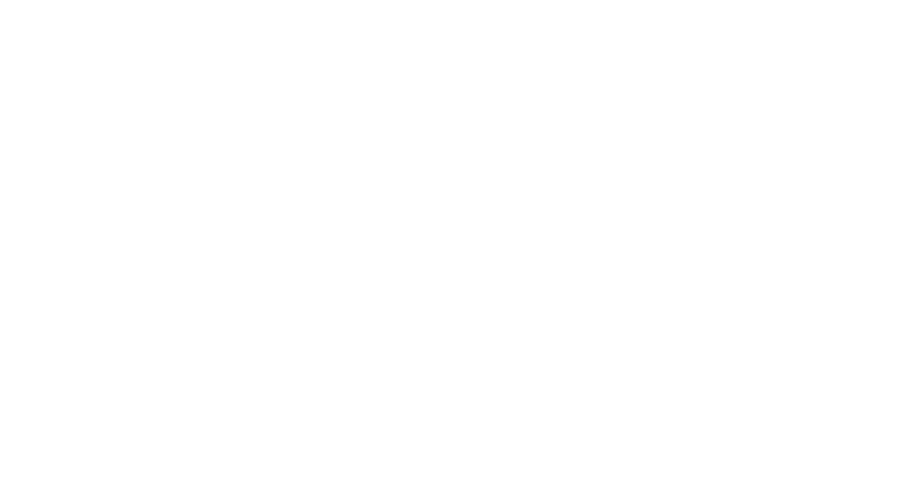

<IPython.core.display.Javascript object>


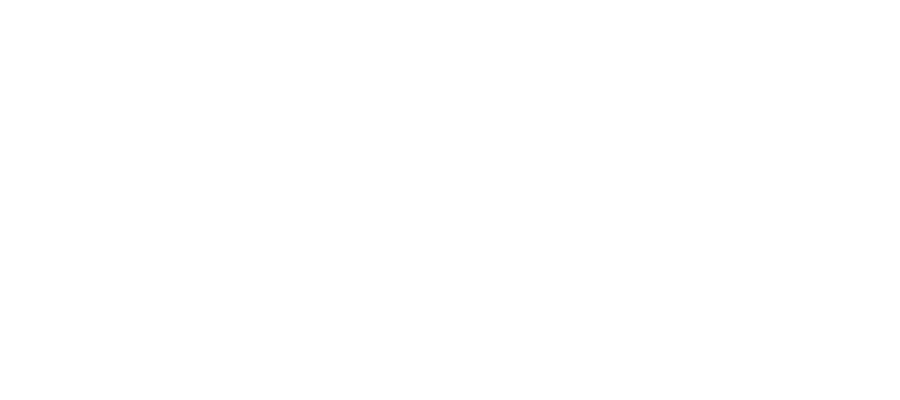

<IPython.core.display.Javascript object>


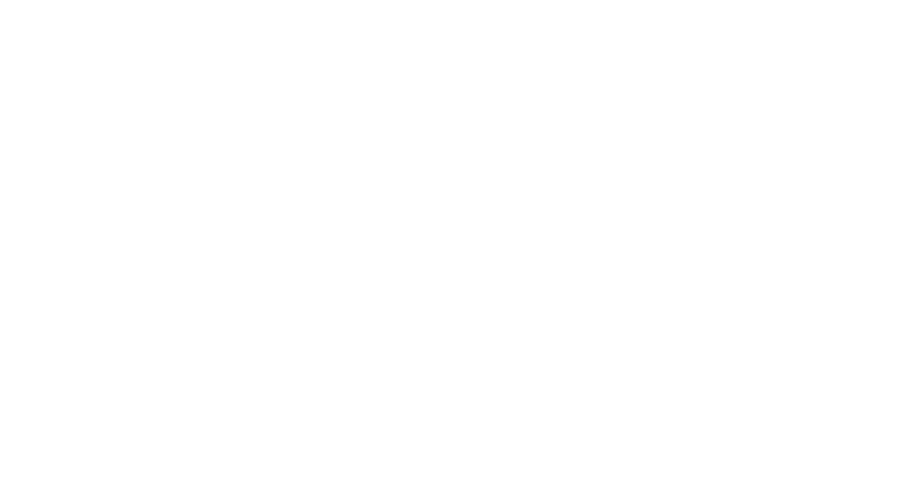

<IPython.core.display.Javascript object>


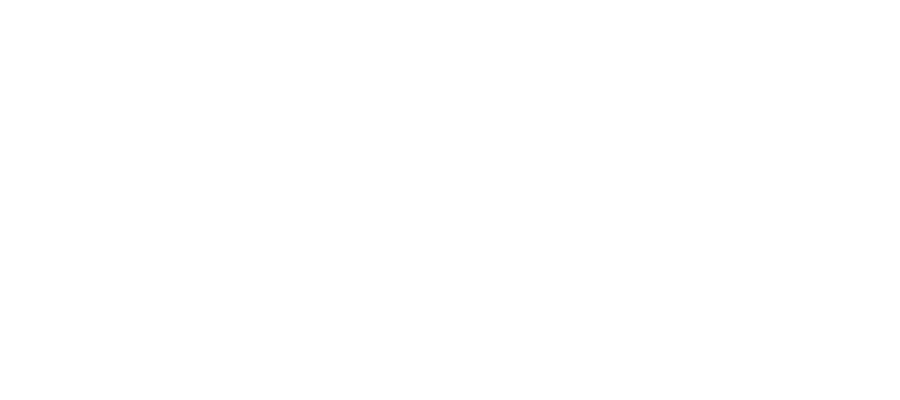

<IPython.core.display.Javascript object>


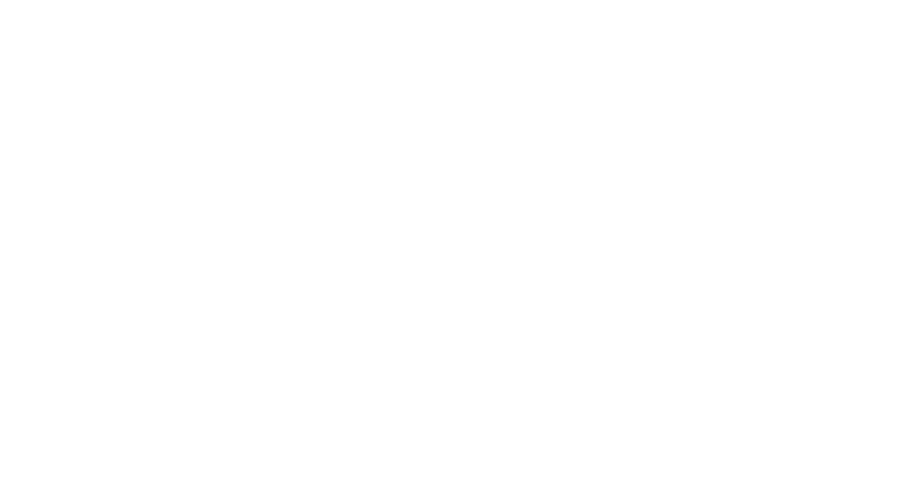

<IPython.core.display.Javascript object>


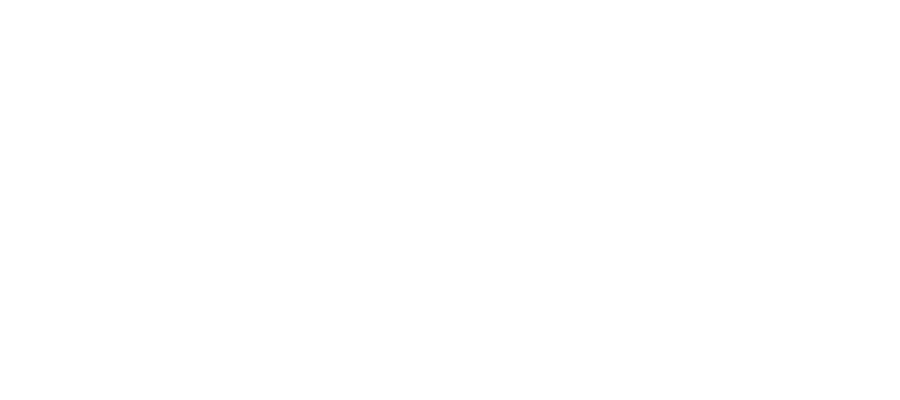

<IPython.core.display.Javascript object>


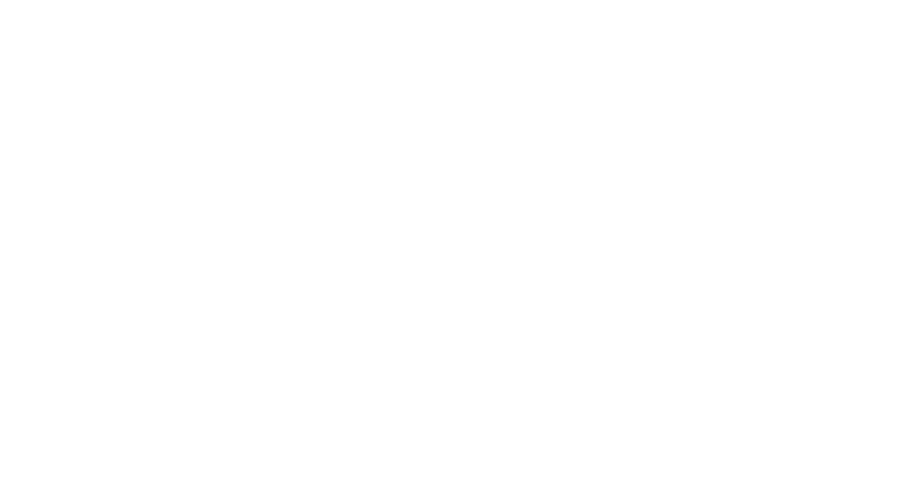

In [429]:
for run_dir in run_dirs[1:]:
    model=dfm.DFlowModel.load(run_dir)
    rg=RotoGrowth(model)
        
    t_str=utils.strftime(model.run_start,"%Y%m%dT%H%M")
    
    fn=os.path.join(roto_dir,f"growth_map-{t_str}.png")
    fig=rg.fig_panels()
    fig.savefig(fn,dpi=150)
    plt.close(fig)
    
    fn=os.path.join(roto_dir,f"growth_dist-{t_str}.png")
    fig=rg.fig_scatter()
    fig.savefig(fn,dpi=150)
    plt.close(fig)


In [434]:
# Extract growth rates and stuff into one dataset
rgs=RotoGrowthSeries(run_dirs=run_dirs[1:])
ds=rgs.process()
ds.to_netcdf(os.path.join(roto_dir,'growth_summary.nc'))

In [435]:
# Aggregate information over the whole run
ds=xr.open_dataset(os.path.join(roto_dir,'growth_summary.nc'))

In [436]:
rgs=RotoGrowthSeries(ds=ds)


<IPython.core.display.Javascript object>


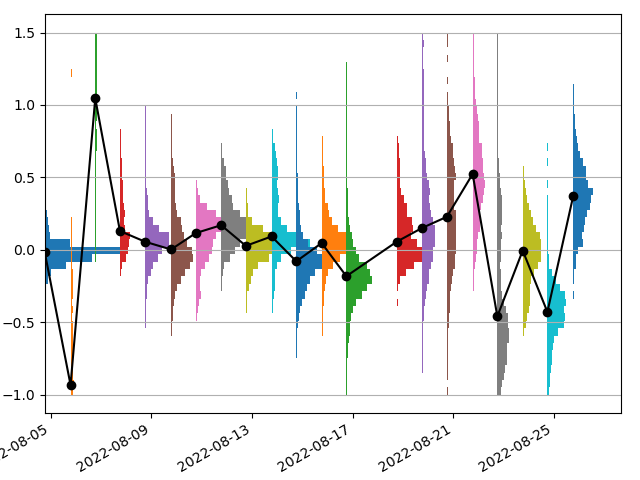

In [437]:
rgs.plot_agg_growth()

# Swimming

1. How much the loss of conservation in the vertical screws things up. Maybe not too bad? For now will use the depth-averaged weight to normalize.
2. Look at how much changes in vertical distribution might explain changing concentrations (i.e. ignoring growth effect, just effect on RS observation). Since the current setup uses a depth-uniform IC, then we should naturally get an upper bound on the apparent growth due to swimming.


In [462]:
# Extract growth rates and stuff into one dataset
rgs=RotoGrowthSeries(run_dirs=run_dirs[1:],weight_var='weight1',weight_value_var='wvalue1',
                    normalize='davg')
ds=rgs.process()
ds.to_netcdf(os.path.join(roto_dir,'growth_summary-weight1-davg.nc'))

<IPython.core.display.Javascript object>


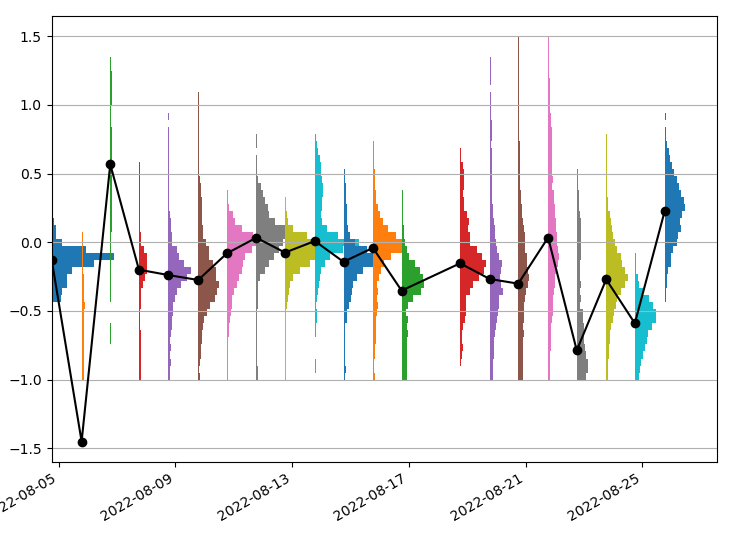

In [461]:
rgs=RotoGrowthSeries(ds=ds)
rgs.plot_agg_growth()

That assumed that each day the water column starts off mixed and is allowed to stratify in time before the next RS scene. This puts an upper bound on the effect, and we can see that the effect is more than enough to offset apparent growth from the RS data. Most days have negative growth.

<IPython.core.display.Javascript object>


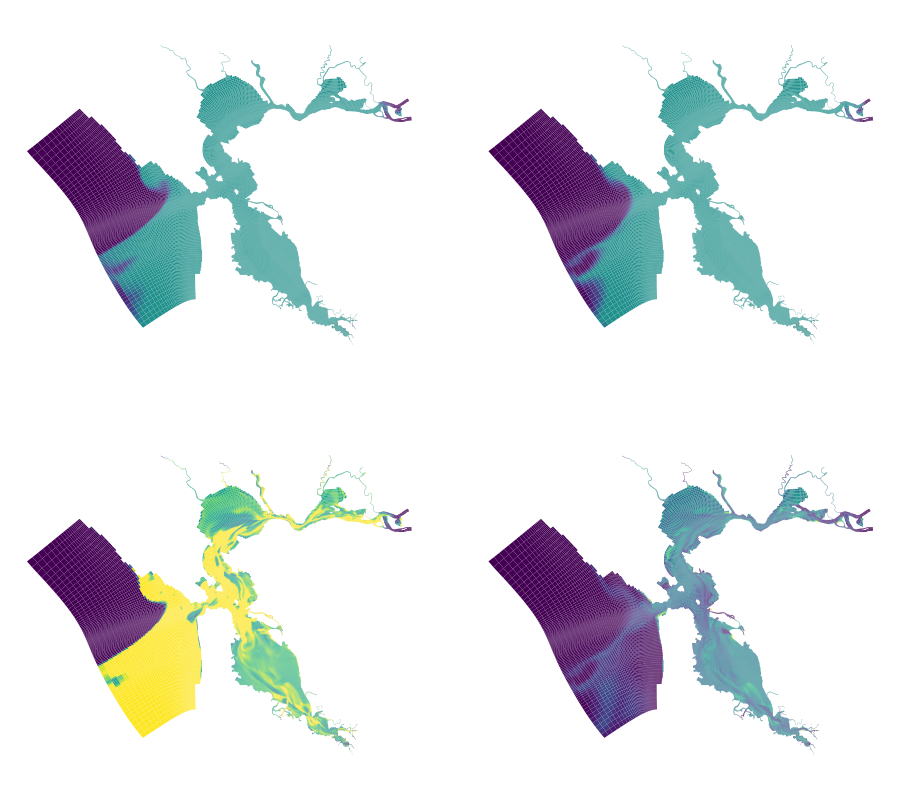

In [472]:
# Check the uniform field, make sure it ran okay and we can use it for setting ICs.
# odd how much the coastal ocean is flushed. 
fig,axs=plt.subplots(2,2,figsize=(9,8))
grid=map_ds.grid

tidx=-1
clim=[0,2]
grid.plot_cells( values=map_ds.uniform0.isel(time=tidx,laydim=-1).values, clim=clim, ax=axs[0,0])
grid.plot_cells( values=map_ds.uniform0.isel(time=tidx,laydim=0).values, clim=clim, ax=axs[0,1])

grid.plot_cells( values=map_ds.uniform1.isel(time=tidx,laydim=-1).values, clim=clim, ax=axs[1,0])
grid.plot_cells( values=map_ds.uniform1.isel(time=tidx,laydim=0).values,  clim=clim, ax=axs[1,1])

for ax in axs.ravel():
    ax.axis('off')
    
fig.subplots_adjust(left=0.03,right=0.97,top=0.97,bottom=0.03)

<IPython.core.display.Javascript object>


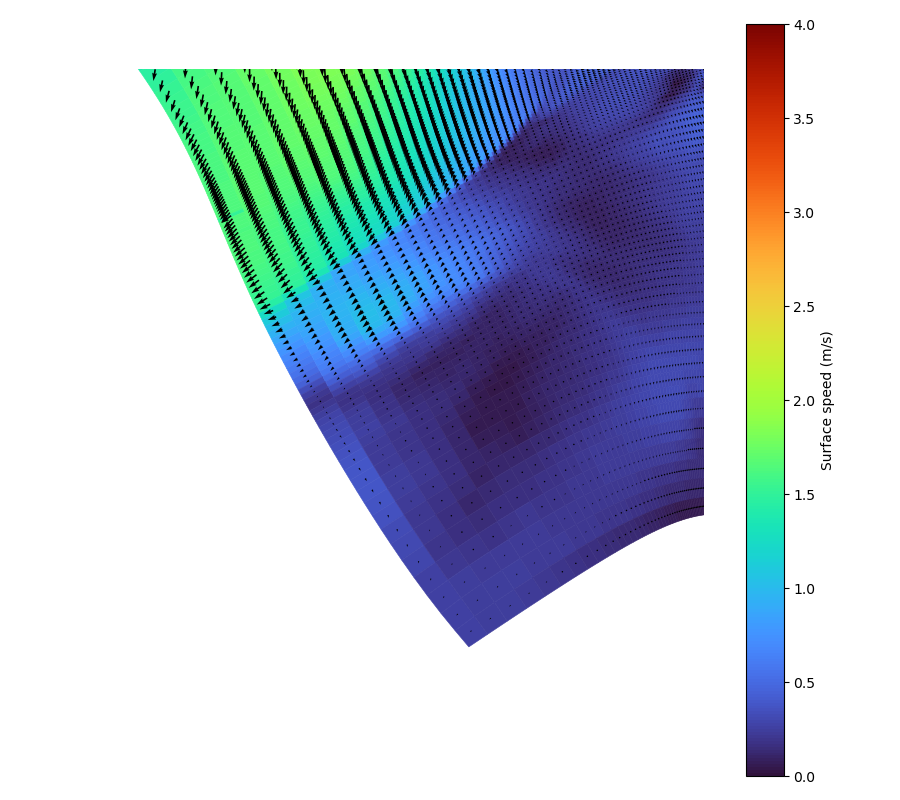

In [480]:
# Check the surface velocity field. concerning how much the coastal ocean is flushed. 
fig,ax=plt.subplots(1,1,figsize=(9,8))
grid=map_ds.grid

tidx=-1
clim=[0,4.0]
surface_u=map_ds.isel(time=tidx,laydim=-1)['ucx'].values
surface_v=map_ds.isel(time=tidx,laydim=-1)['ucy'].values

surface_speed=np.sqrt(surface_u**2+surface_v**2)

coll=grid.plot_cells(values=surface_speed, clim=clim, ax=ax, lw=0.4, edgecolor='face',
                     cmap='turbo')

cc=grid.cells_center()
ax.quiver( cc[:,0], cc[:,1], surface_u,surface_v)

ax.axis('off')
plt.colorbar(coll,label='Surface speed (m/s)')    
fig.subplots_adjust(left=0.03,right=0.97,top=0.97,bottom=0.03)

In [473]:
list(map_ds)

['mesh2d_enc_x',
 'mesh2d_enc_y',
 'mesh2d_enc_node_count',
 'mesh2d_enc_part_node_count',
 'mesh2d_enc_interior_ring',
 'mesh2d_enclosure_container',
 'Mesh2D',
 'projected_coordinate_system',
 'NetNode_z',
 'NetLink',
 'NetLinkType',
 'NetElemNode',
 'NetElemLink',
 'NetLinkContour_x',
 'NetLinkContour_y',
 'NetLink_xu',
 'NetLink_yu',
 'BndLink',
 'FlowElem_zcc',
 'FlowElem_bac',
 'FlowElem_xzw',
 'FlowElem_yzw',
 'FlowElemContour_x',
 'FlowElemContour_y',
 'FlowElem_bl',
 'ElemLink',
 'FlowLink',
 'FlowLinkType',
 'FlowLink_lonu',
 'FlowLink_latu',
 'FlowElemDomain',
 'FlowLinkDomain',
 'FlowElemGlobalNr',
 'timestep',
 's1',
 'waterdepth',
 'Tair',
 'rhum',
 'clou',
 'Qsun',
 'Qeva',
 'Qcon',
 'Qlong',
 'Qfreva',
 'Qfrcon',
 'Qtot',
 'numlimdt',
 'taus',
 'unorm',
 'ucz',
 'ucxa',
 'ucya',
 'ww1',
 'ucx',
 'ucy',
 'sa1',
 'tem1',
 'weight0',
 'wvalue0',
 'uniform0',
 'weight1',
 'wvalue1',
 'uniform1',
 'turkin1',
 'vicwwu',
 'tureps1',
 'windx',
 'windy',
 'windxu',
 'windyu']